## Validation of users by Income + job title regression

In this notebook, I aim to perform the final validation of the user voordinates via regression between Income and estimated SES. 
The validation includes:
- Simple linear Regression and multiple linear regression (ordinary least squares) on coordinates and income for nine different models*
- *Model comparison between nine different configurations of markers included in the network
    - Goofness of fit characteristics
- End result is identification of the best marker configuration for obtaining the best linreg fit

In [1]:
import os
import re
import sys
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

# Local application imports
sys.path.insert(0, '../Utility files')
import utils2
from utils2 import *

In [13]:
path =  '/home/livtollanes/NewData/french/'
file  = 'french_edgelist_marker_threshold.csv'

t = pd.read_csv(path + file)    

In [22]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
# print(t.groupby('type')['twitter_name'].apply(lambda x: list(x.unique())))
print(t.groupby('type')['twitter_name'].nunique())

type
Lycées professionels        7
chain restaurants           7
clubs de football          18
commerce                    8
ecoles de commerce          9
grande distribution        11
luxe vetements et malls    13
magazine                   34
media                      28
party                      26
sport                      22
universities               40
Name: twitter_name, dtype: int64


## 1 Connect job titles and income information to all coordinate files

First and foremost, I need to add all the income + job information per user to each of the nine coordinate files m1-m9
Create a function that:
- Iterates over each file system, from n=1 to n=9
- Removes all users that do not occur in the job title file onlygreenscleaned

In [2]:
#Load the income + job title data
path= '/home/livtollanes/10.jan-thesis/Code/Validation/Data/'
file = 'onlygreens_cleaned.csv'
jobs = pd.read_csv(path + file, index_col= 0, dtype={'follower_id': str})

In total, we have 11 684 unique users with a job title after preprocessing

### some stats

In [21]:
# #Some job category stats
# pd.set_option('display.max_rows', None)
# jobs['title'] = jobs['title'].str.strip()
# print(jobs['PCS_ESE_name'].value_counts().sort_index())

#jobs['PCS_ESE_name'].nunique() #111 key words/titles, and 58 job categories

PCS_ESE_name
Adjoints administratifs des collectivités locales                                                 347
Aides à domicile, aides ménagères, travailleuses familiales                                         4
Aides-soignants                                                                                    34
Allocataires de la recherche publique                                                             273
Animateurs socioculturels et de loisirs                                                             6
Architectes salariés                                                                               85
Artisans salariés de leur entreprise                                                               45
Artistes de la danse                                                                               16
Artistes de la musique et du chant                                                                356
Artistes dramatiques                                                 

Just to reiterate, these are the models (which markers are included?):
- m1:All
- m2: Remove party
- m3: Remove media, party, university
- m4: Remove media, party, university, football
- m5: Remove media, party, university, lux and vetements and football
- m6: Remove media, party, university, clearly lux brands, and football
- m7: Include only things you can buy (restaurants, commerce, grande distr. Luxe et vet, sport)
- m8: Magazine, media only
- m9: Education, ecole de commerce, lycees only


From these nine models, which contain coordinates for user populations of variable sizes, I am selecting the user coordinates that have job titles. Thus, the final model testing here will be on even smaller sample sizes. 

In [3]:
#Create CA job coord files
importlib.reload(utils2)
#Create the user coordinate files for all models - for users with job titles

dfs1 = []  # list to store all dataframes

for file_number in range(1, 10):  # loop over the coordinate files for models 1 to 9
    filtered_df = utils2.filter_add_jobs_coords(file_number, jobdf=jobs)
    dfs1.append(filtered_df)  # add the filtered dataframe to the list

# Now dfs is a list of all the filtered dataframes


# # Load dfs into variables 
# df1 = dfs[0] 
# df2 = dfs[1] 
# df3 = dfs[2]
# df4 = dfs[3] 
# df5 = dfs[4] 
# df6 = dfs[5] 
# df7 = dfs[6] 
# df8 = dfs[7] 
# df9 = dfs[8] 


for i, df in enumerate(dfs1):
    print(f"Shape of dataframe {i+1}: {df.shape}")

Constructed file path: /home/livtollanes/NewData/coordinates/m1_coords/m1_row_coordinates.csv
Constructed file path: /home/livtollanes/NewData/coordinates/m2_coords/m2_row_coordinates.csv
Constructed file path: /home/livtollanes/NewData/coordinates/m3_coords/m3_row_coordinates.csv
Constructed file path: /home/livtollanes/NewData/coordinates/m4_coords/m4_row_coordinates.csv
Constructed file path: /home/livtollanes/NewData/coordinates/m5_coords/m5_row_coordinates.csv
Constructed file path: /home/livtollanes/NewData/coordinates/m6_coords/m6_row_coordinates.csv
Constructed file path: /home/livtollanes/NewData/coordinates/m7_coords/m7_row_coordinates.csv
Constructed file path: /home/livtollanes/NewData/coordinates/m8_coords/m8_row_coordinates.csv
Constructed file path: /home/livtollanes/NewData/coordinates/m9_coords/m9_row_coordinates.csv
Shape of dataframe 1: (11678, 14)
Shape of dataframe 2: (11677, 14)
Shape of dataframe 3: (10958, 14)
Shape of dataframe 4: (10681, 14)
Shape of dataframe

## 2 Assumption Checks


BEfore assessing the best dimension for describing the relationship between SES and INCOME, I must find the best model.
I will fit two multiple linear regression models on all nine model_dfs: one  classic and one heirarchical, taking PCE_ESE into account. 

- Models will be compared based on some yet to be determined goodness of fit characteristic. RMSE, R-squared, etc.
- Once the best model_df has been found, further inspection will be done on this to determine impact of dimensions. 


In [2]:
# Loading CA job coord files

importlib.reload(utils2)

dfs = []  # list to store all dataframes

for file_number in range(1, 10):  # loop over the coordinate files for models 1 to 9
    filtered_df = utils2.load_CA_model_files(file_number)
    dfs.append(filtered_df)  # add the filtered dataframe to the list

for i, df in enumerate(dfs):
    print(f"Shape of dataframe {i+1}: {df.shape}")

# Replace spaces in column names with underscores
for df in dfs:
    df.columns = df.columns.str.replace(' ', '_')

Used file path: /home/livtollanes/NewData/job_title_coordinates/m1_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m2_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m3_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m4_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m5_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m6_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m7_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m8_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m9_jobs_rowcoords.csv
Shape of dataframe 1: (11678, 14)
Shape of dataframe 2: (11677, 14)
Shape of dataframe 3: (10958, 14)
Shape of dataframe 4: (10681, 14)
Shape of dataframe 5: (10621, 14)
Shape of dataframe 6: (10626, 14)
Shape of dataframe 7: 

Relationships between Income and SES for 

### OLS Assumption checks for non hierarchical multiple Lin Reg

1. Linearity of outcome var and predictor vars
2. Homoscedasticity - Equal variance
3. Normality of error distribution
4. Independent observations, no autocorrelation 
5. Predictors are not correlated with each other
6. Outliers should not be present too far


https://medium.com/@shuv.sdr/multiple-linear-regression-in-python-4ee79d763e8f



Violations.
4. (observations k and n have nothing in common that the regression model is not already accounting for) - Since we're dealing with grouped data, we likely violate this assumption. 

Model formula: 

Income ~ dim1 + dim2 + dim3, data = [m1...m9]

Something to note:
"The 
𝑋s should be fixed (e. independent variables should impact dependent variables). It should not be the case that dependent variables impact independent variables. This is because, in regression models, the causal relationship is studied and there is not a correlation between the two variables. For example, if you run the regression with inflation as your dependent variable and unemployment as the independent variable, the OLS estimators are likely to be incorrect because with inflation and unemployment, we expect correlation rather than a causal relationship."

In our case, SES and Income cannot really be saparated, because income is a part of the factors used to determine someone's SES. As such, if this assumption was to hold for all regression models, we should not really do a regression, but rather do a correlation analysis. 

#### 1 Linearity of independent and dependent variables - Not really

As the value of the X increases, the value of y should also increase or decrease linearly. If there are multiple independent features, each of the independent features should have a linear relationship with the dependent feature.

I find that none of the predictors, regardless of the data frame (model) used, displays a very clear linear relationship. This is partly because of the large degree of variation within estimates for groups. However, there might be some linear tendencies, suggesting we could use regression to do the model comparison.

/tmp/ipykernel_1538426/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


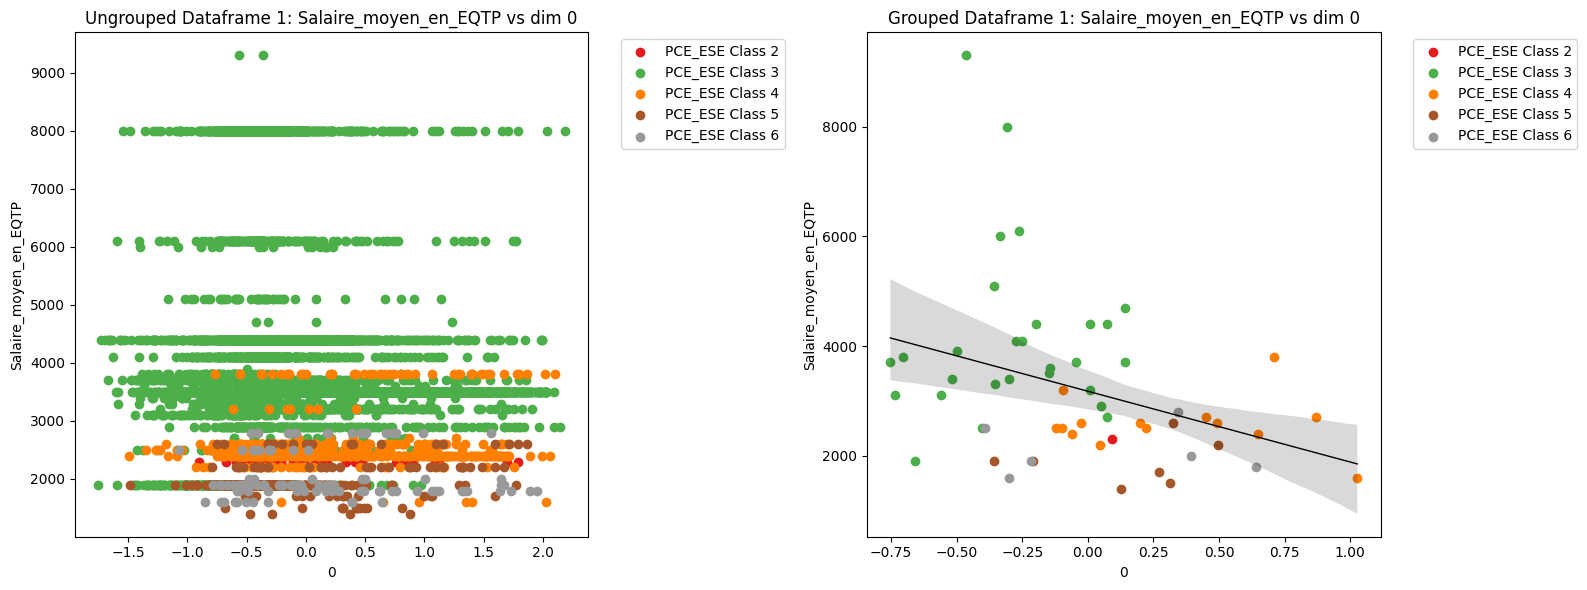

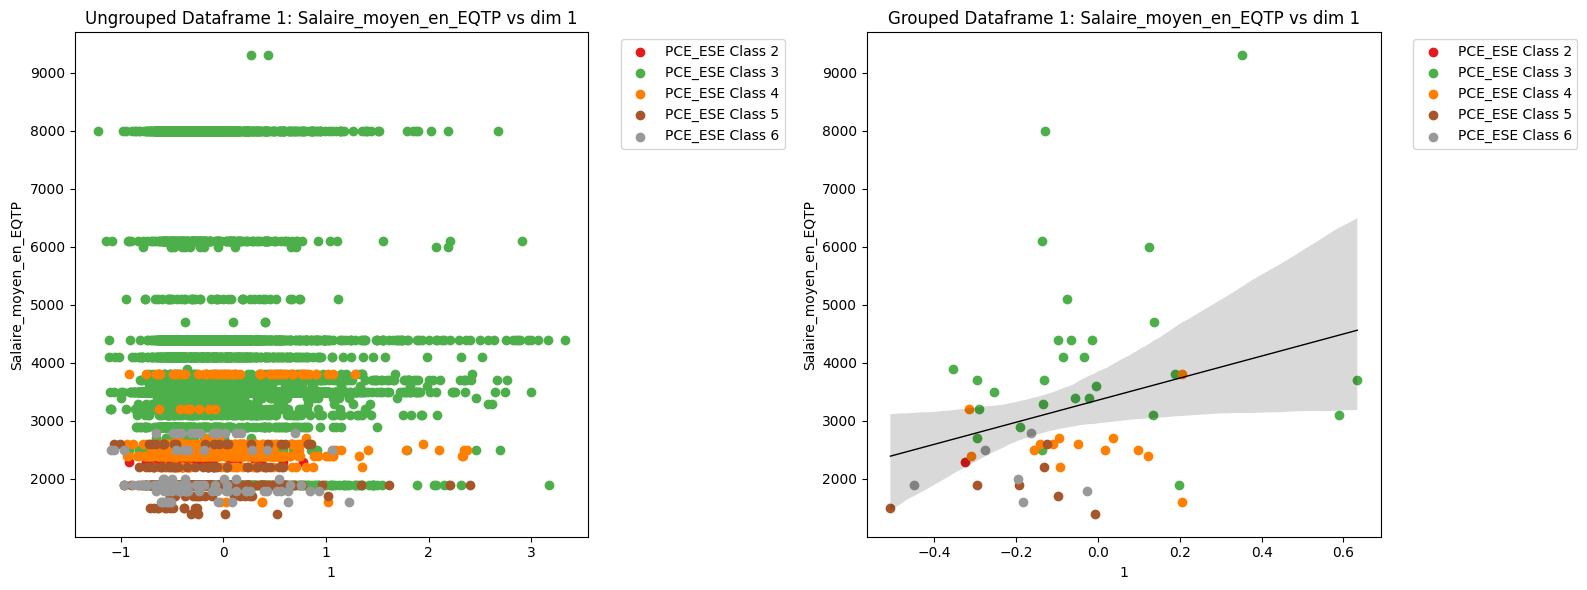

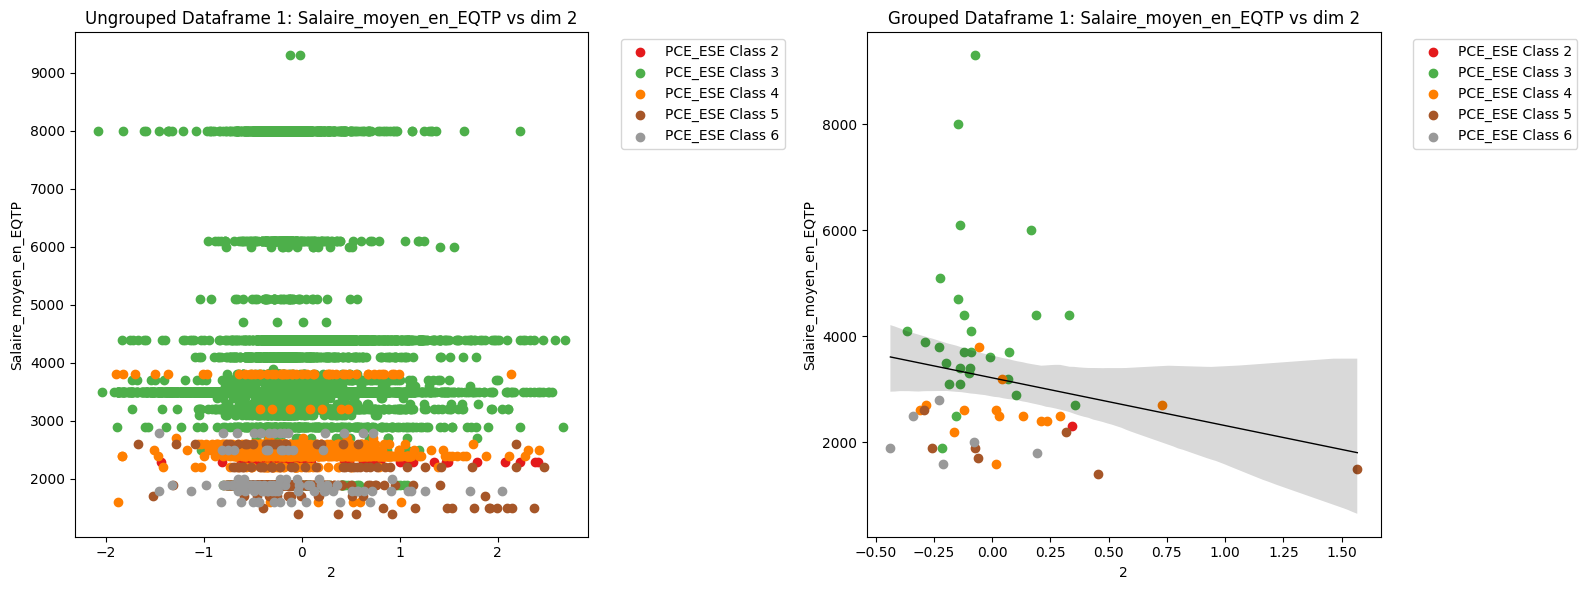

/tmp/ipykernel_1538426/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


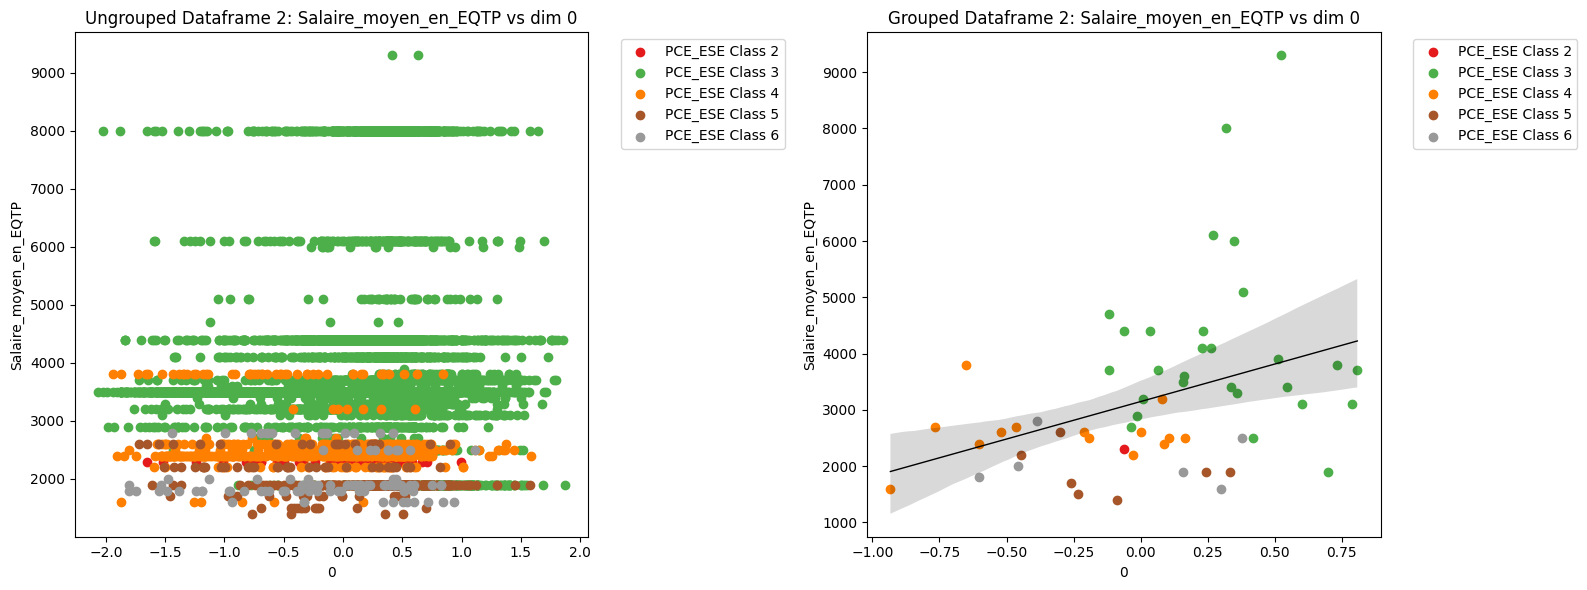

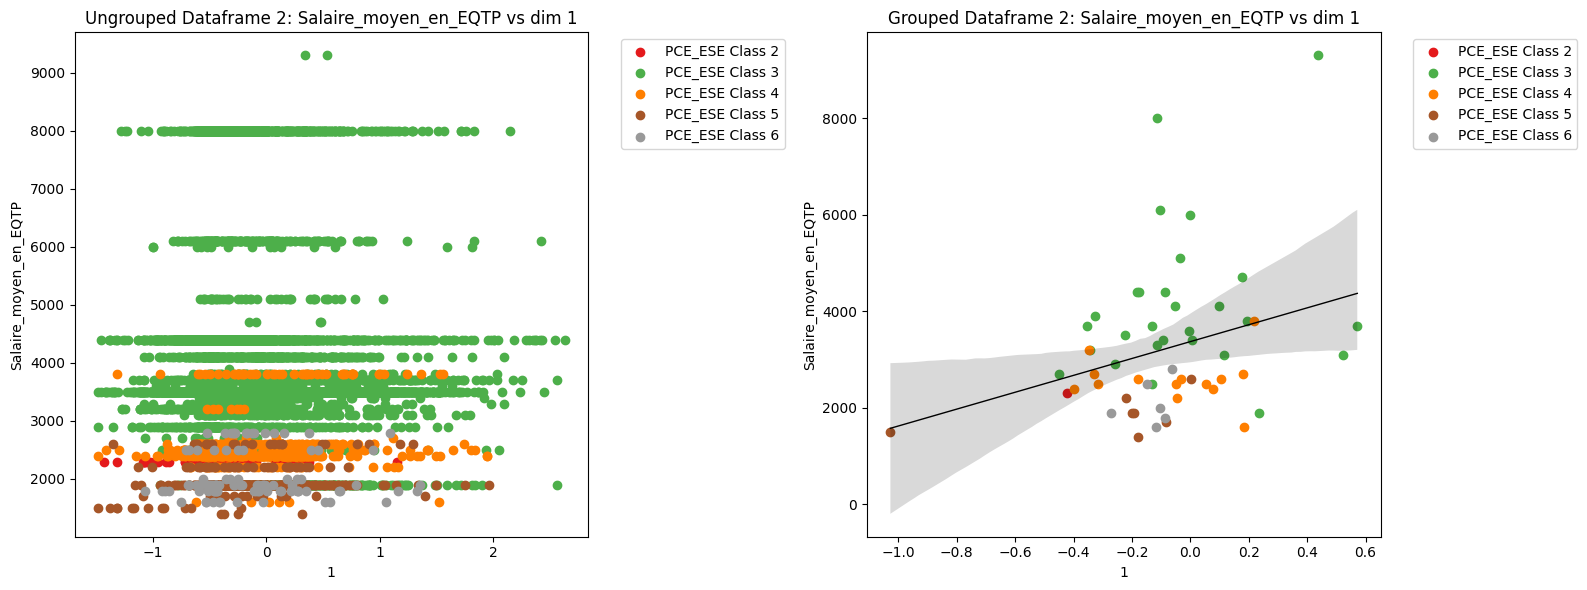

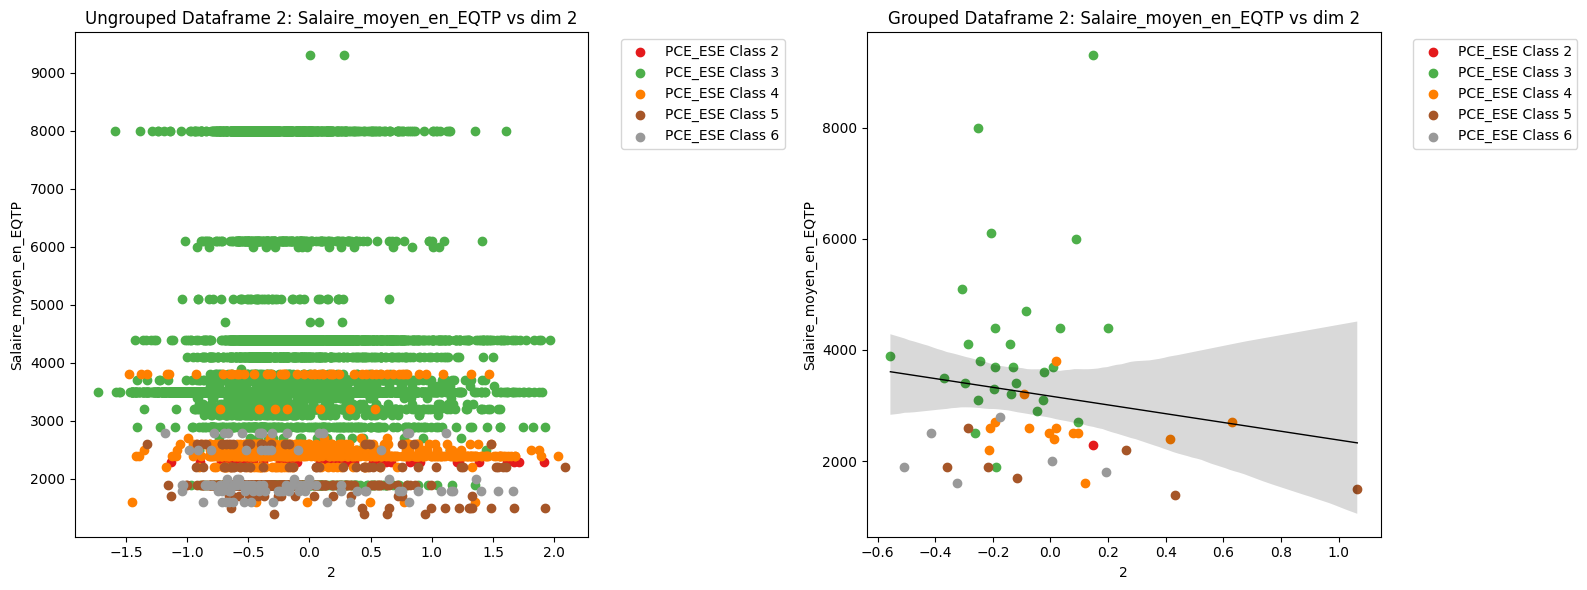

/tmp/ipykernel_1538426/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


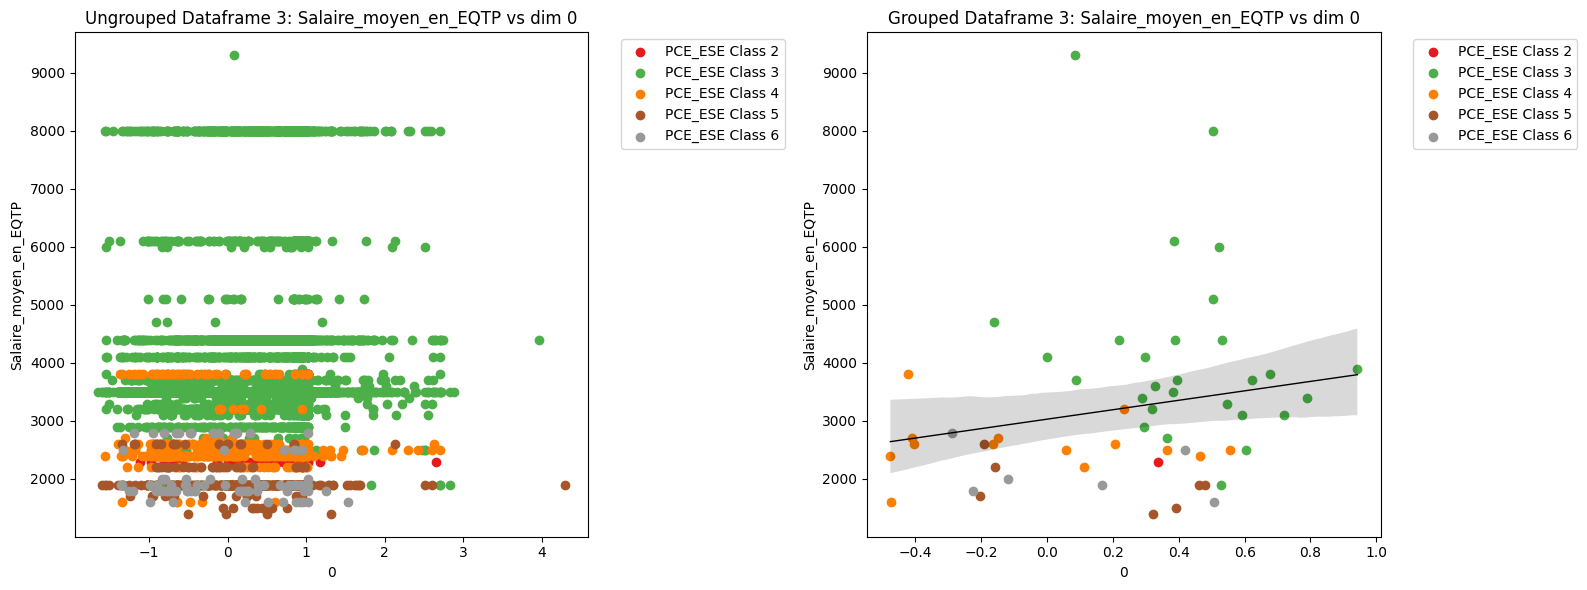

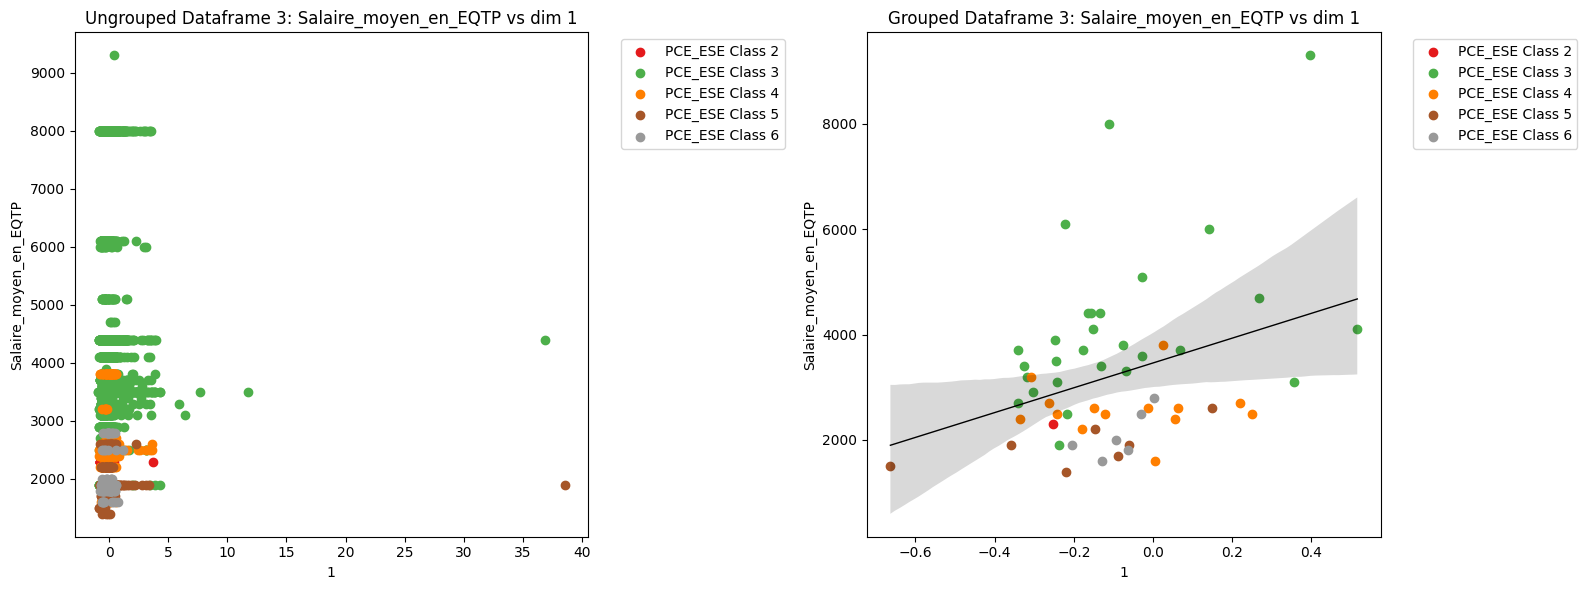

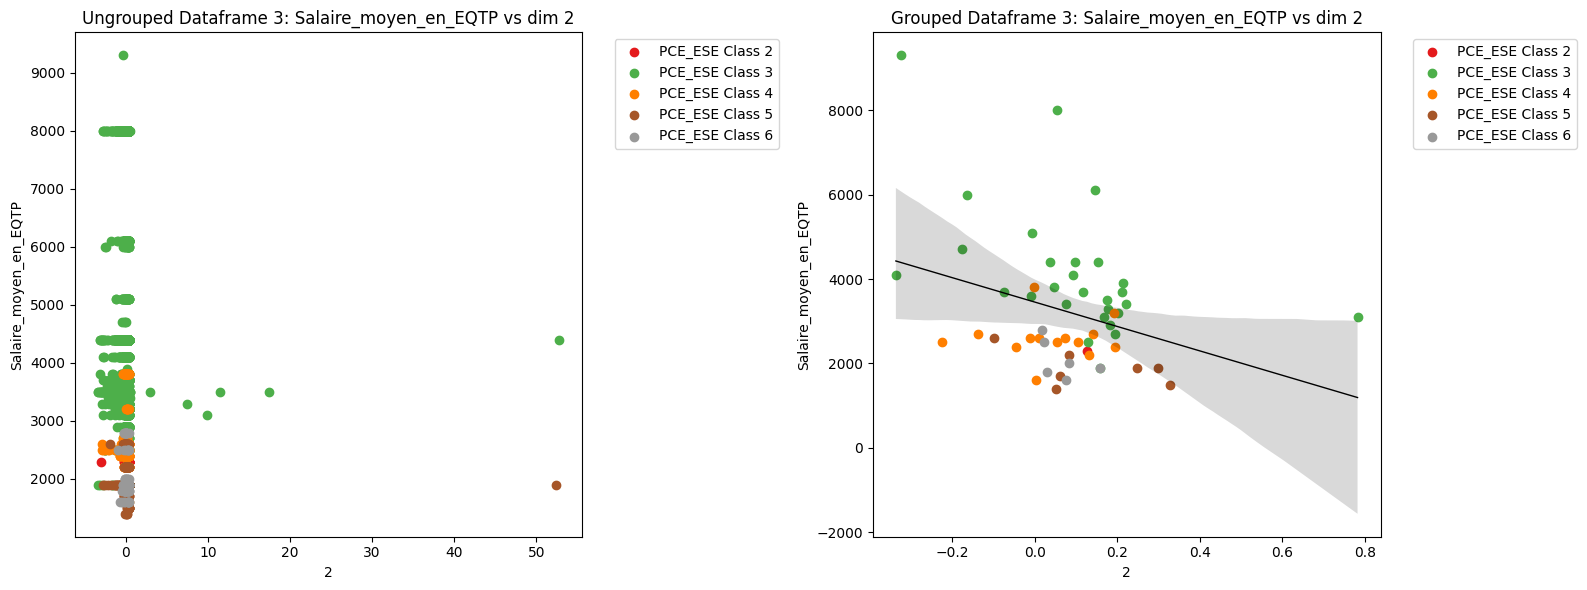

/tmp/ipykernel_1538426/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


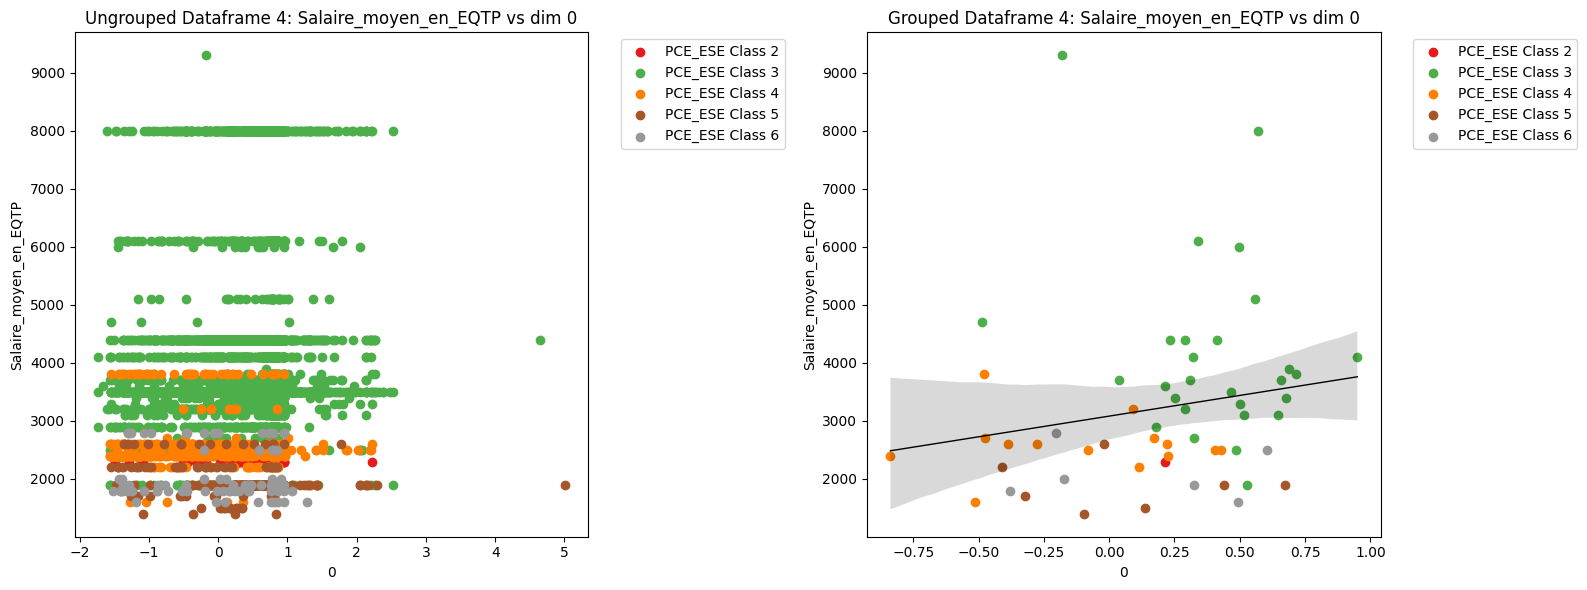

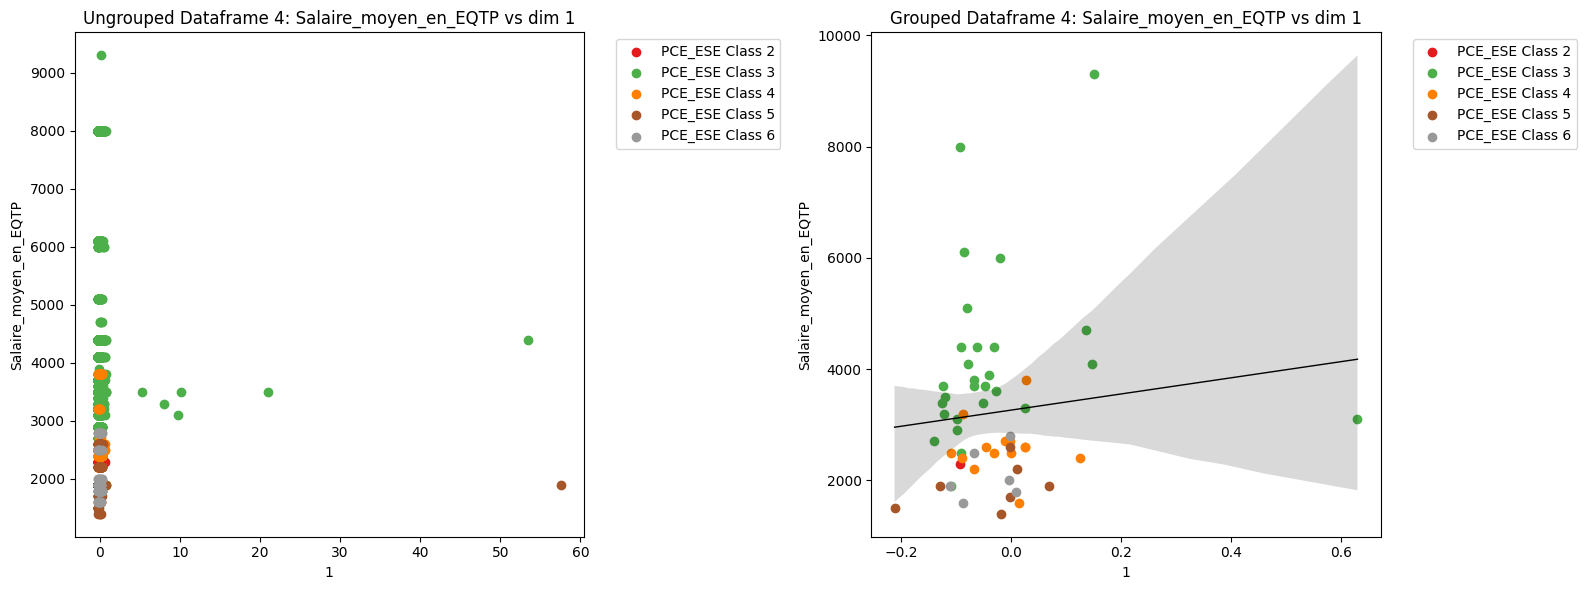

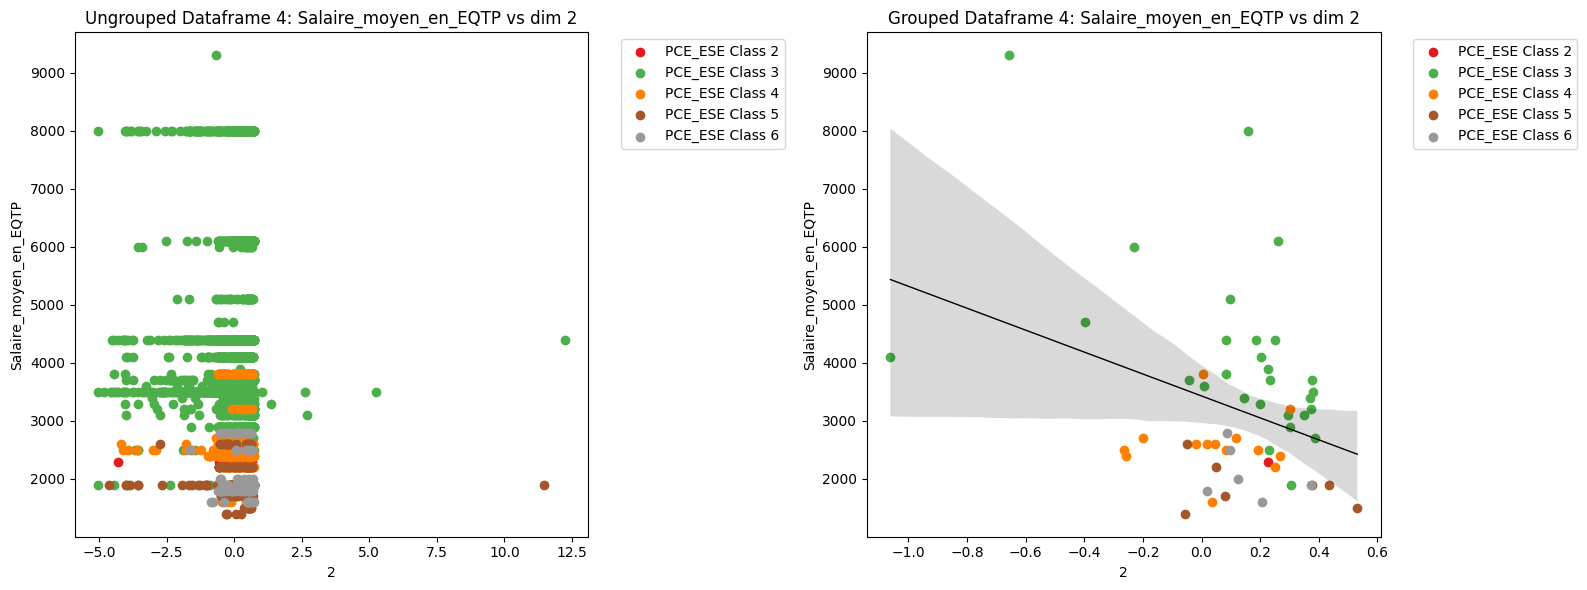

/tmp/ipykernel_1538426/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


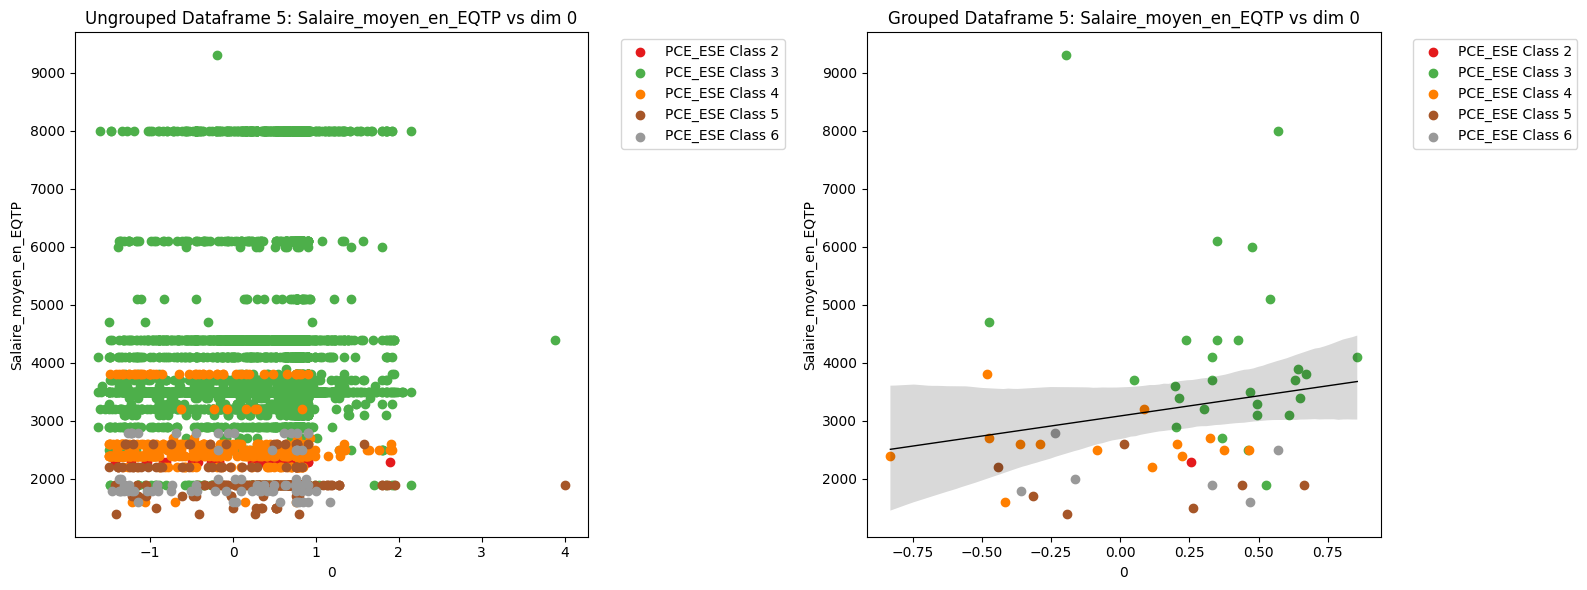

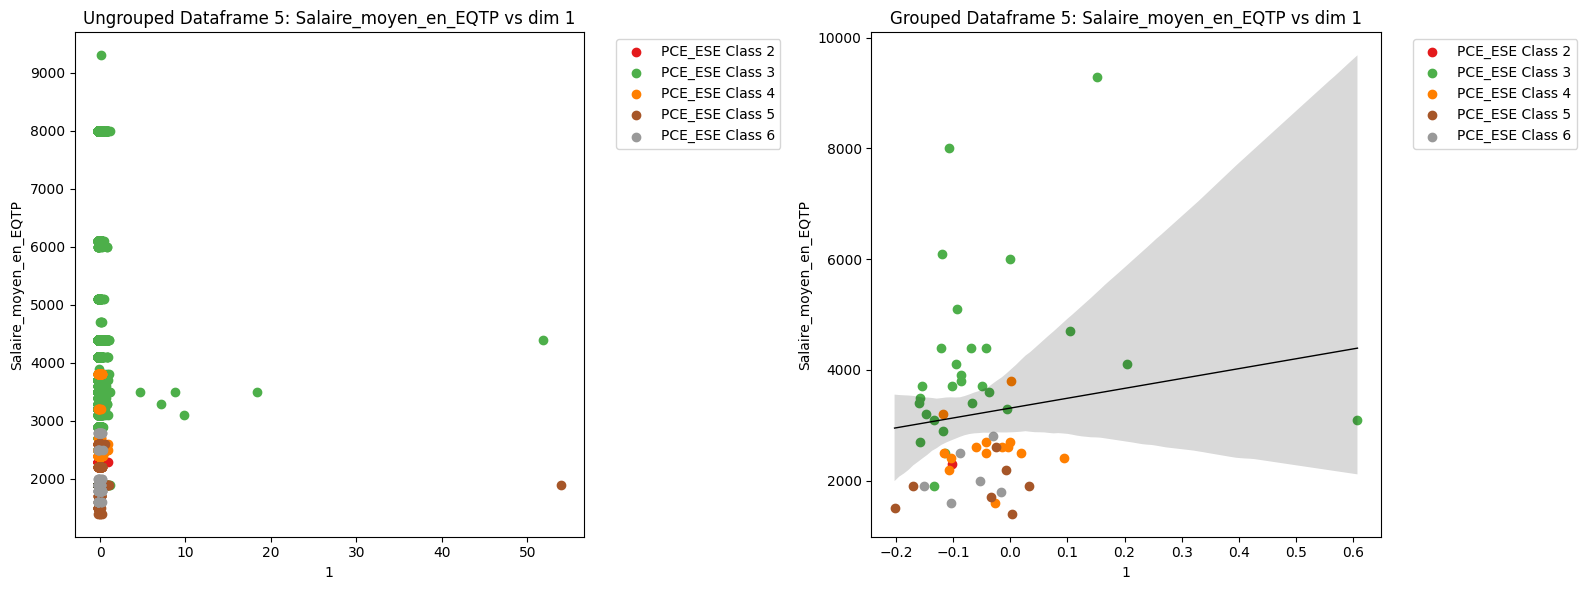

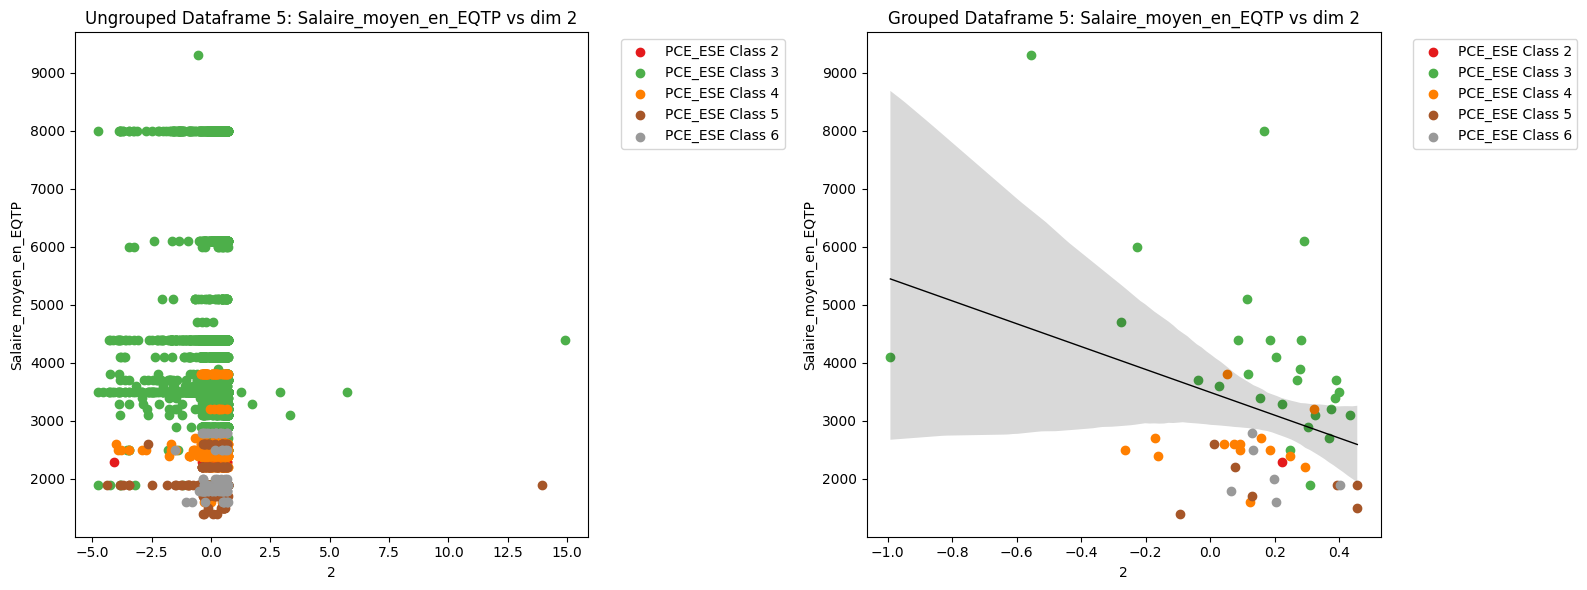

/tmp/ipykernel_1538426/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


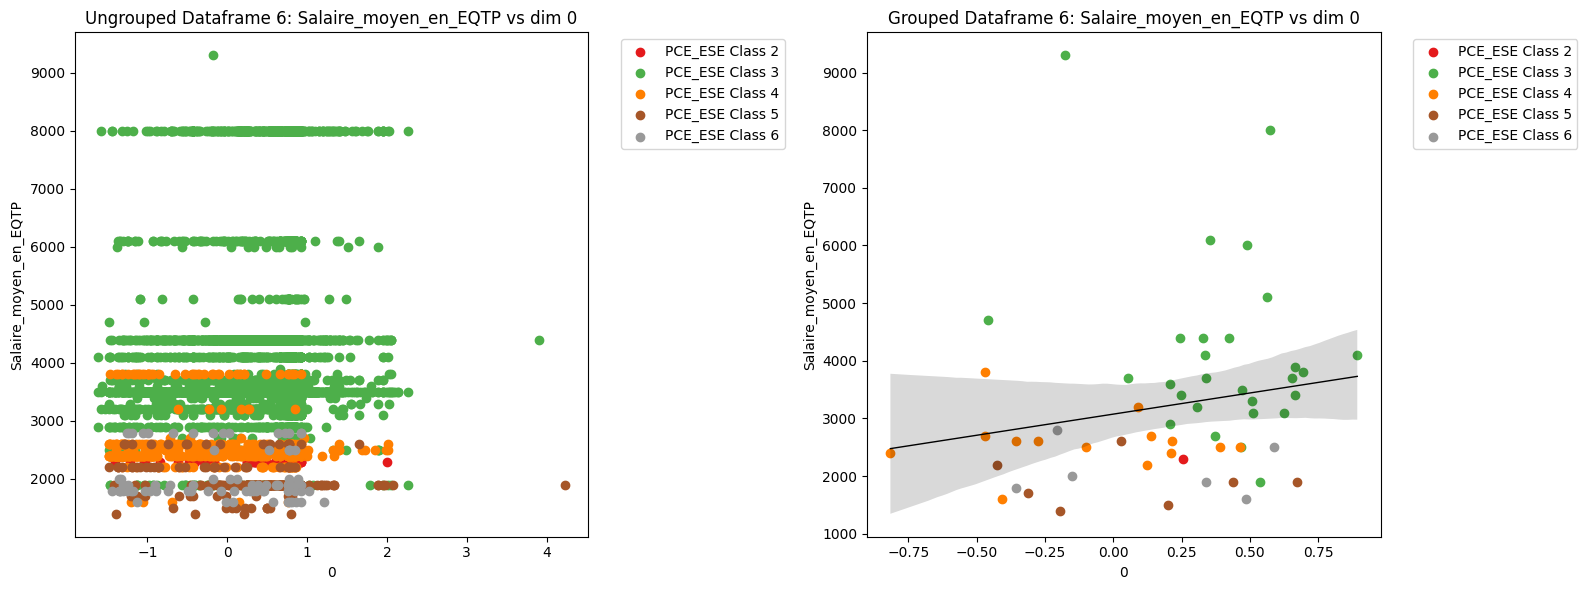

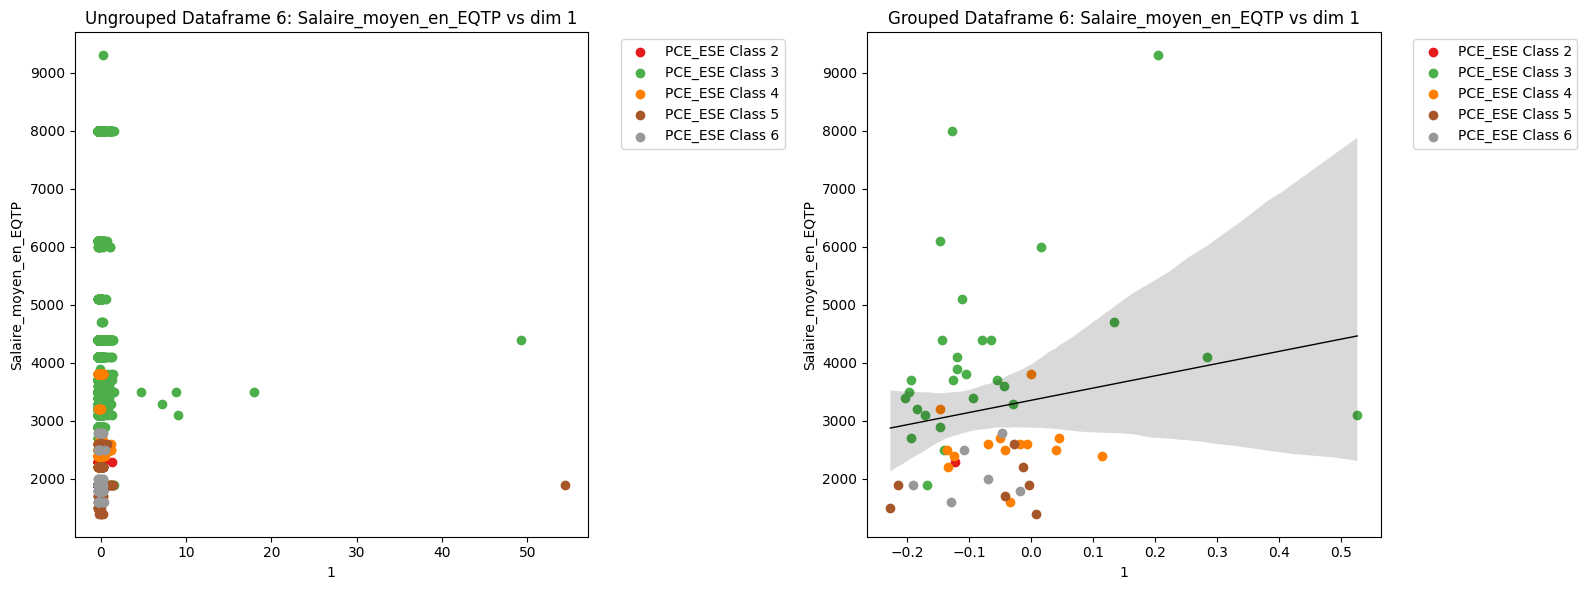

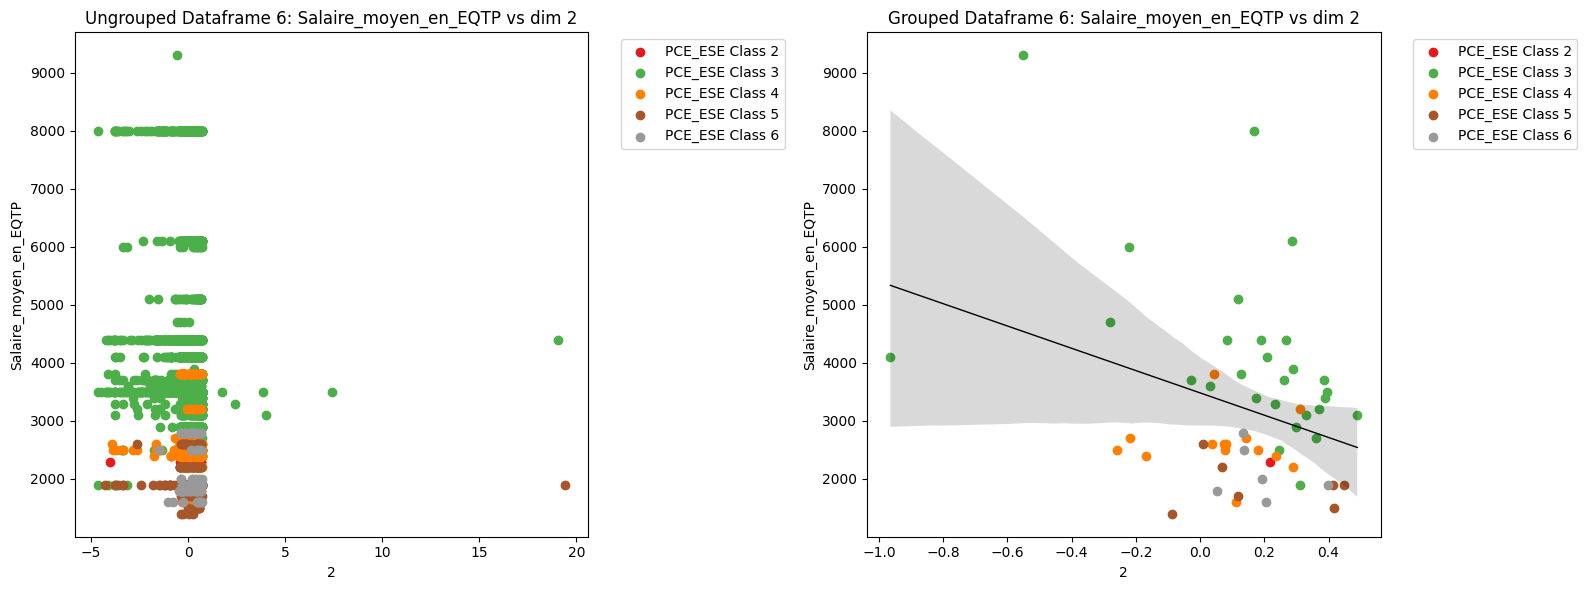

/tmp/ipykernel_1538426/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


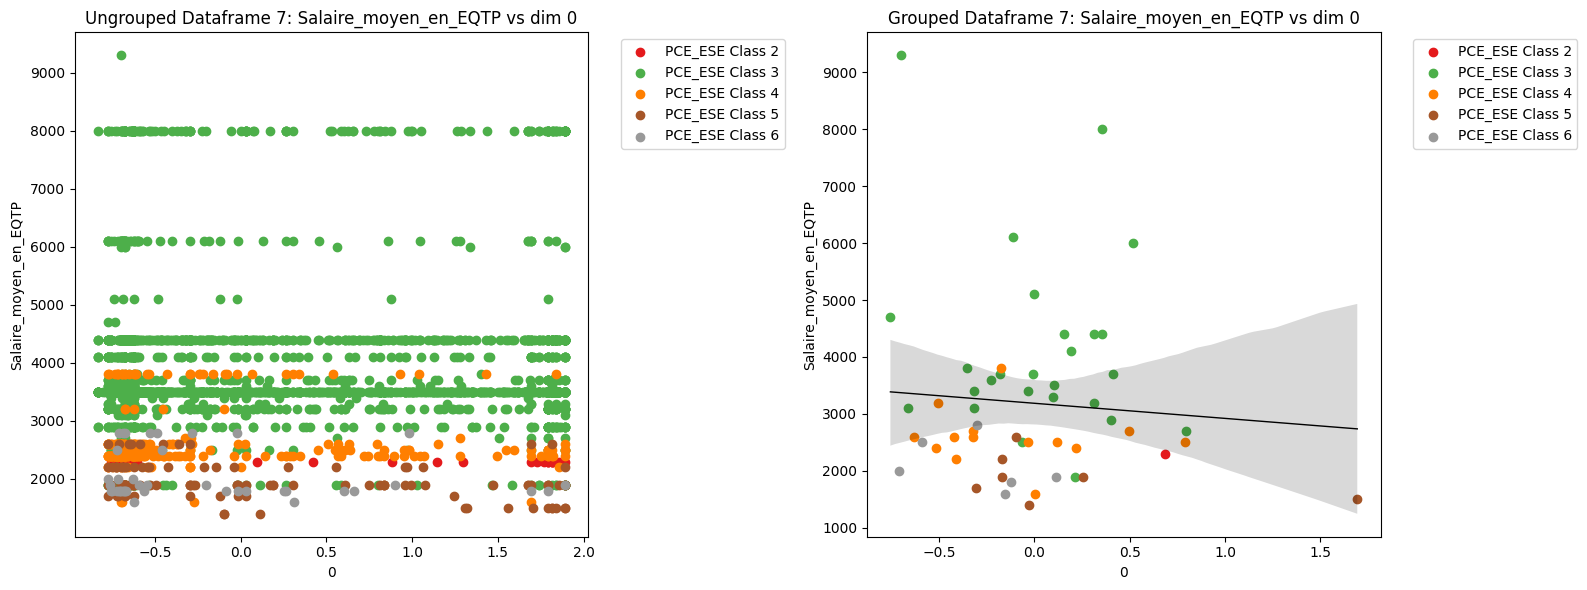

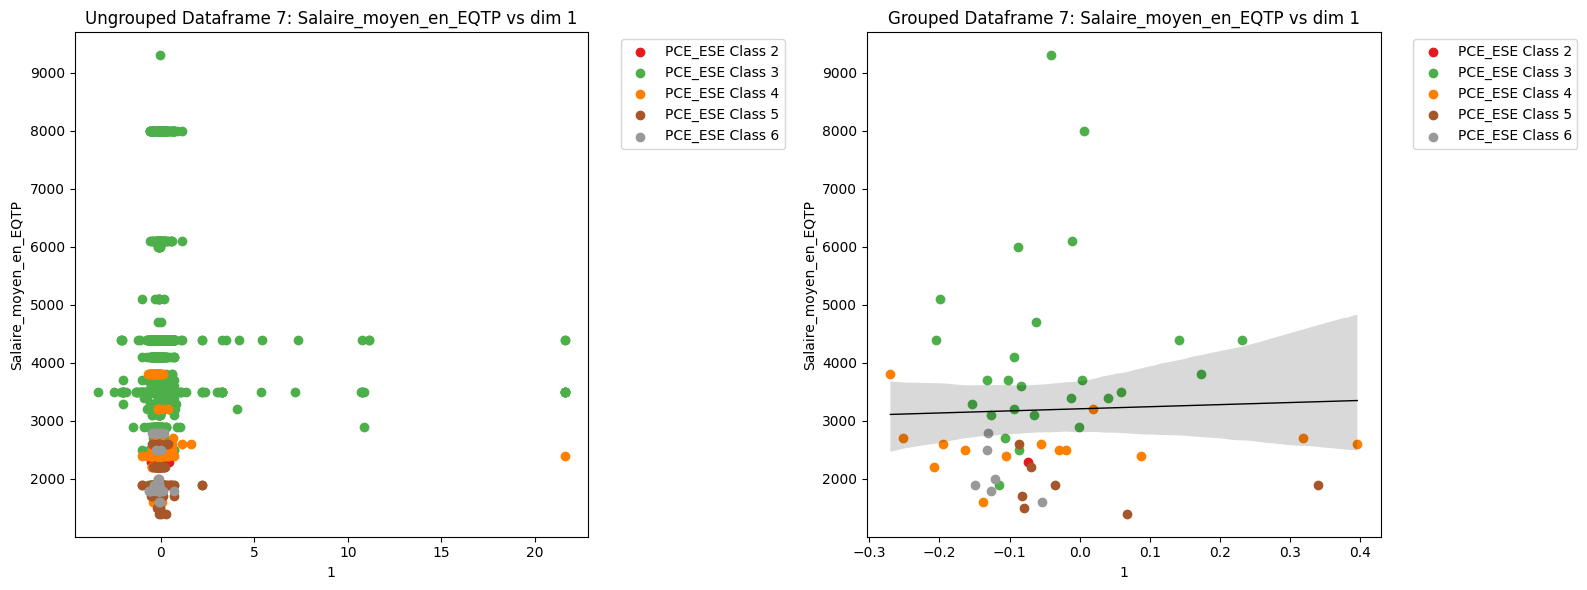

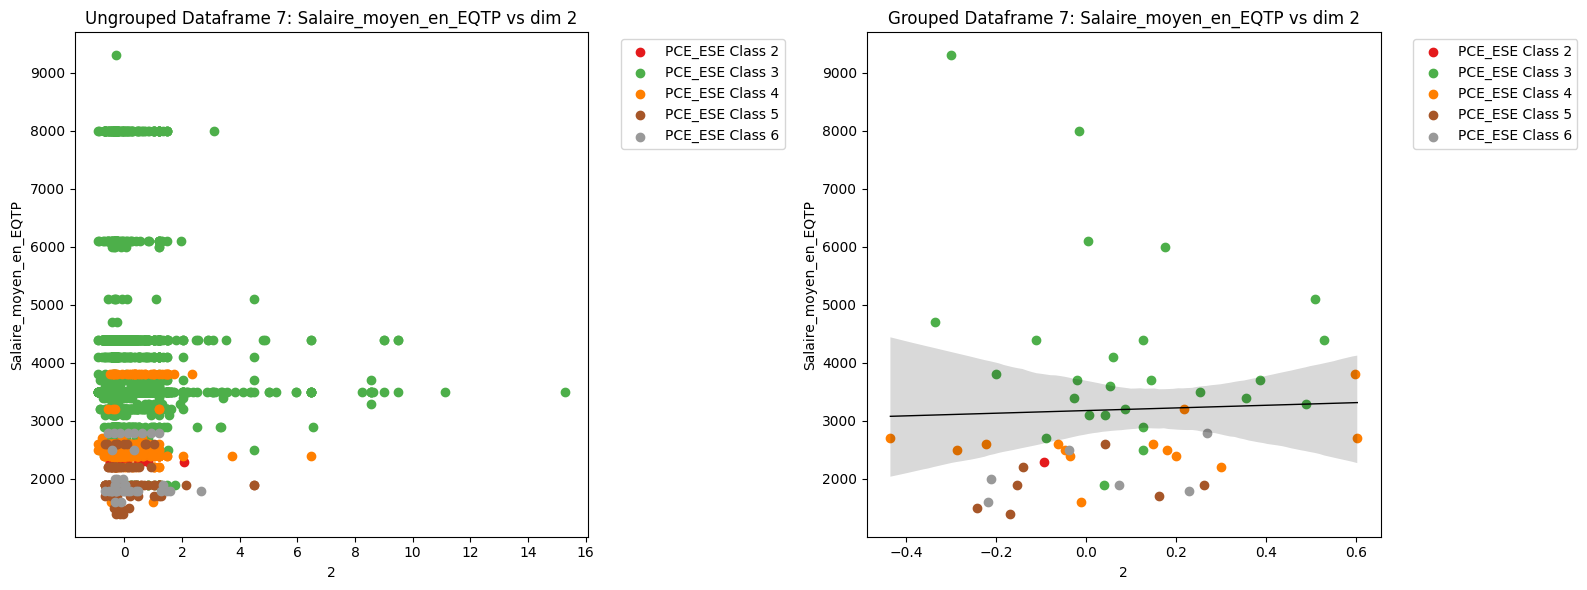

/tmp/ipykernel_1538426/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


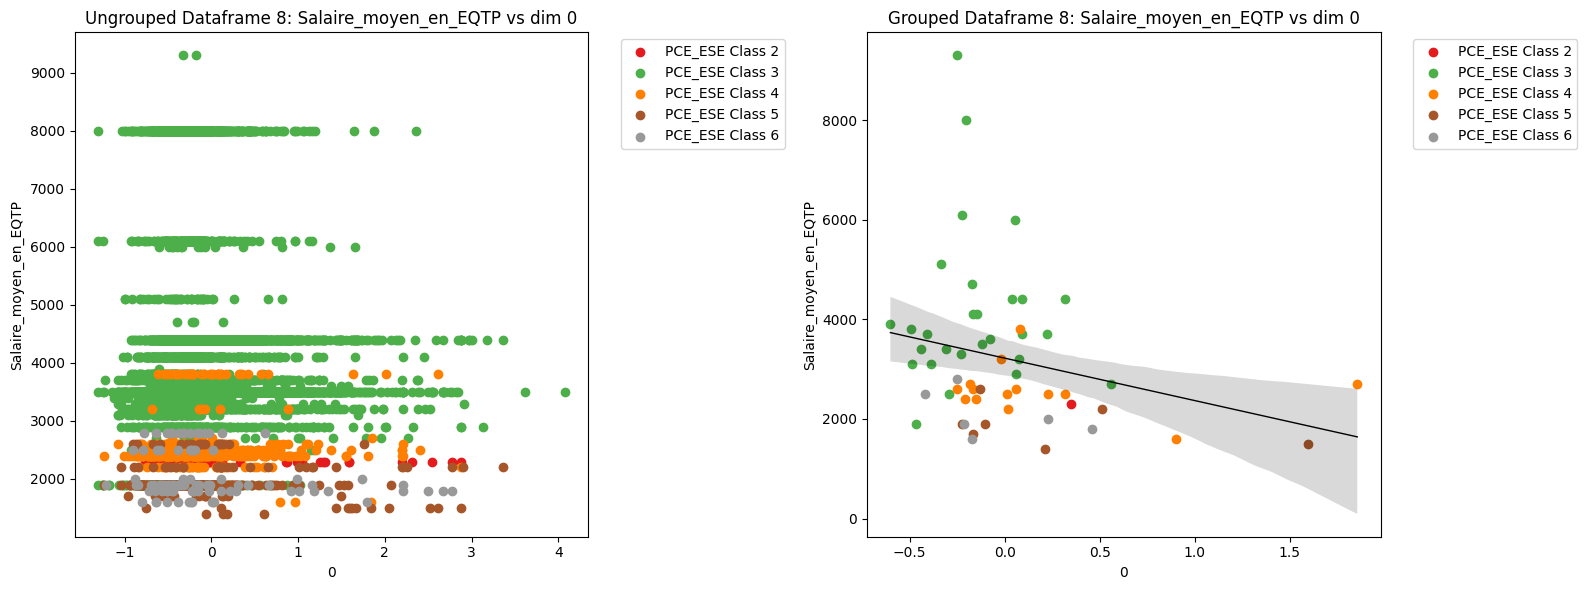

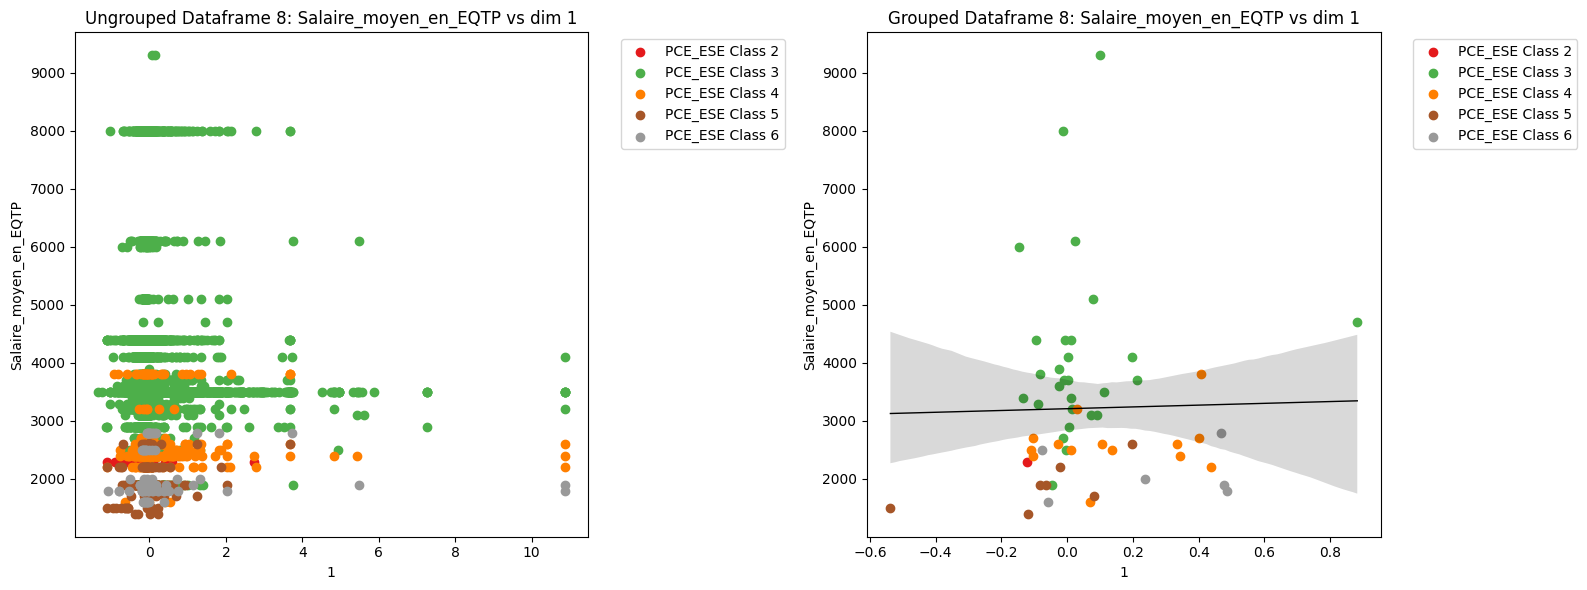

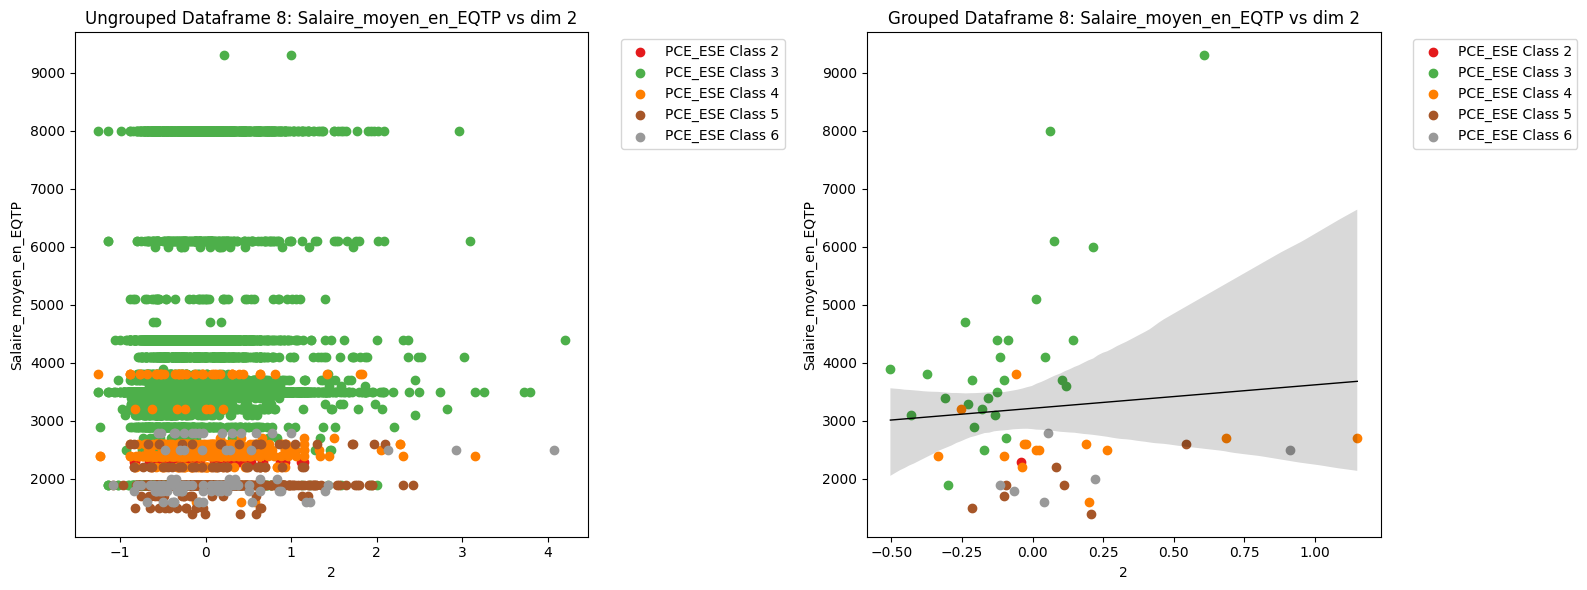

/tmp/ipykernel_1538426/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


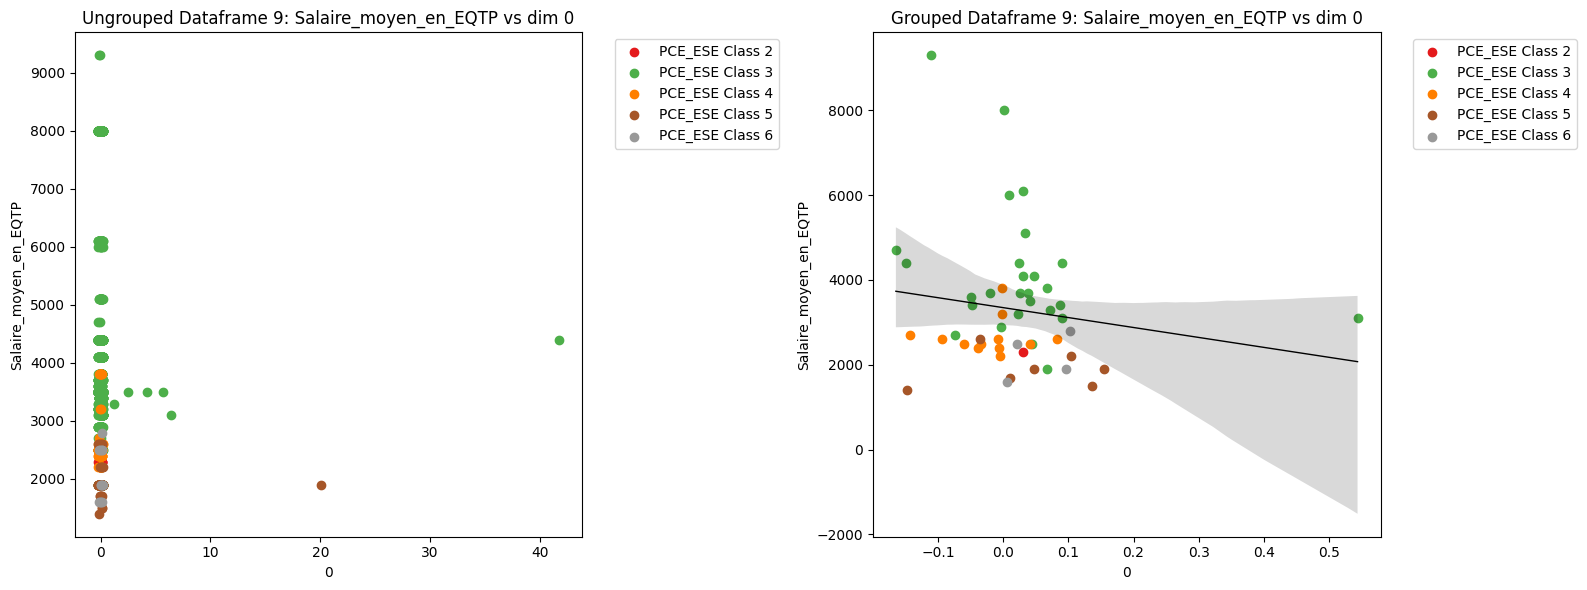

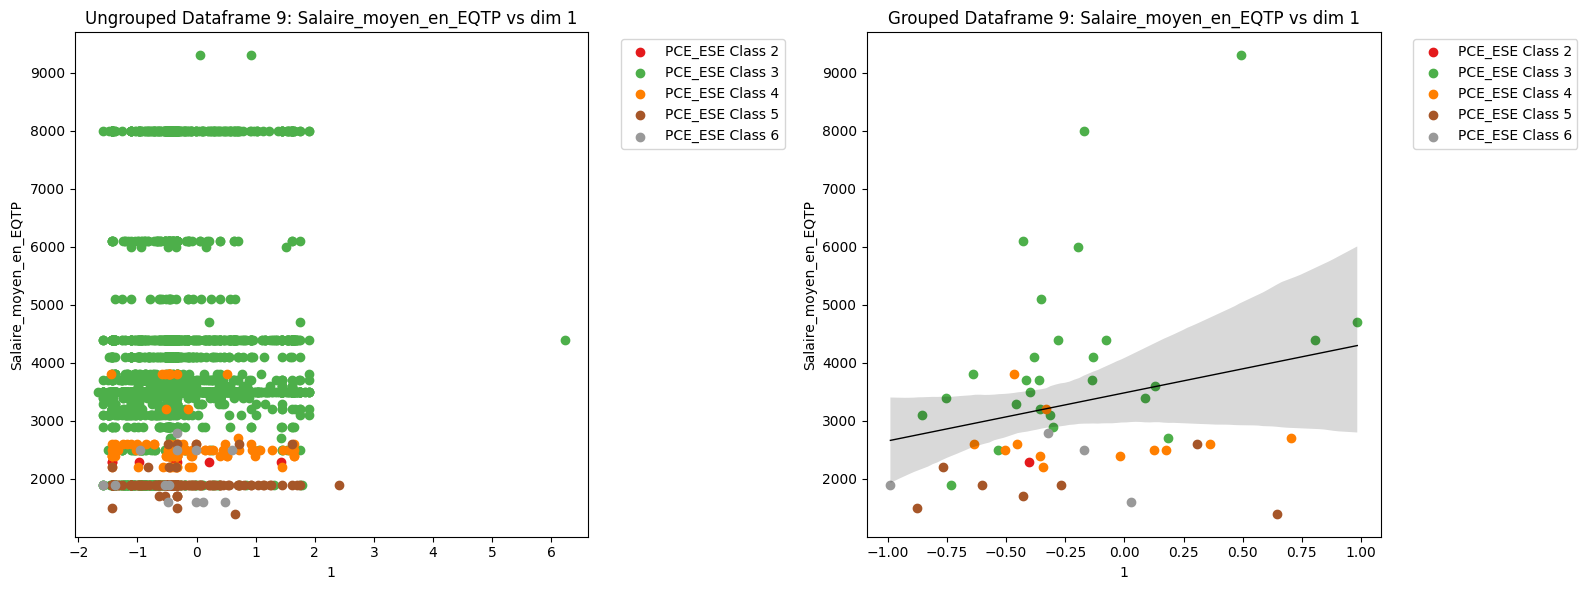

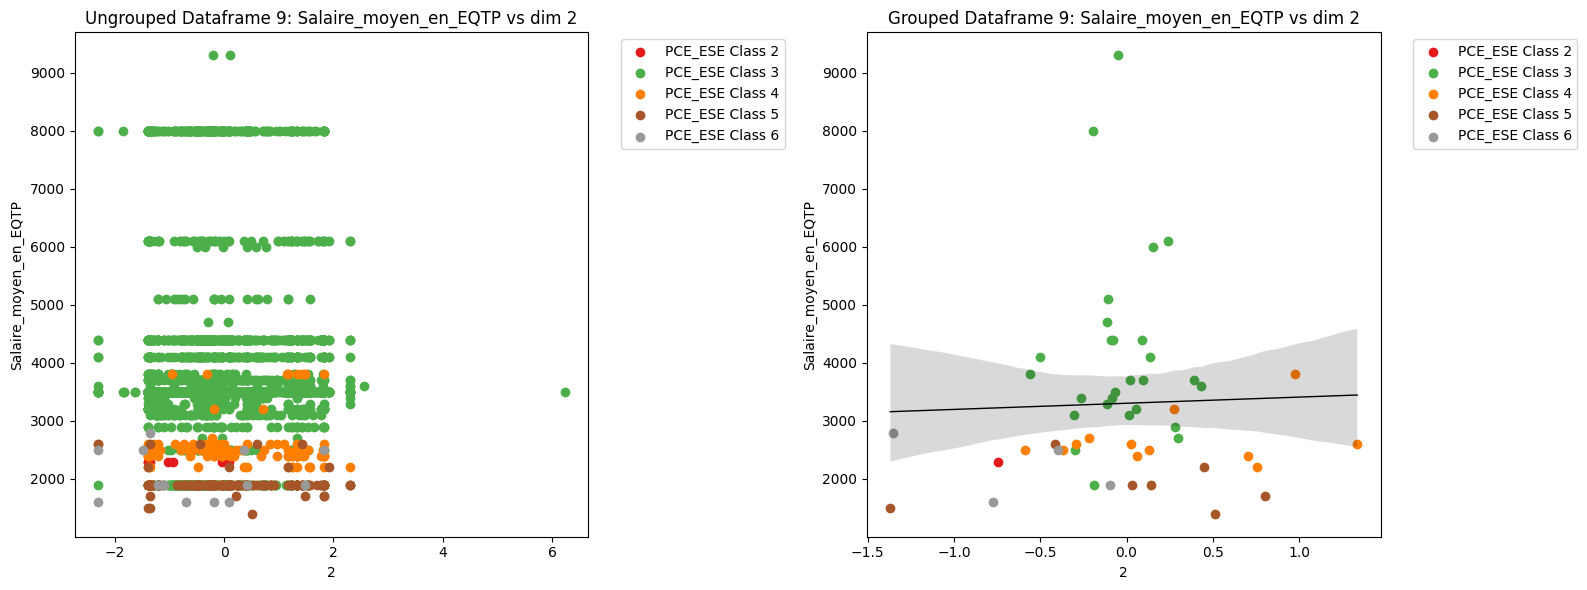

In [5]:
import seaborn as sns

## Not log transformed
outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

# Get unique color categories
color_categories = np.unique(np.concatenate([df['PCS_ESE'].str[0].unique() for df in dfs]))

# Plot scatter plots for each dataframe
for i, df in enumerate(dfs):
    df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
    grouped_df = df.groupby('PCS_ESE')[predictors + [outcome]].mean()  # Grouped data
    grouped_df['color'] = grouped_df.index.str[0].astype(str)
    
    for predictor in predictors:
        plt.figure(figsize=(16, 6))
        
        # Ungrouped data
        plt.subplot(1, 2, 1)
        for color in color_categories:
            plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome], 
                        c=color_map[color], label=f'PCE_ESE Class {color}')
        plt.xlabel(predictor)
        plt.ylabel(outcome)
        plt.title(f'Ungrouped Dataframe {i+1}: {outcome} vs dim {predictor}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Grouped data
        plt.subplot(1, 2, 2)
        for color in color_categories:
            plt.scatter(grouped_df.loc[grouped_df['color'] == color, predictor], 
                        grouped_df.loc[grouped_df['color'] == color, outcome], 
                        color=color_map[color], label=f'PCE_ESE Class {color}')
        sns.regplot(x=grouped_df[predictor], y=grouped_df[outcome], 
                    color='black', scatter=False, ci=95, line_kws={'linewidth': '1'})
        plt.xlabel(predictor)
        plt.ylabel(outcome)
        plt.title(f'Grouped Dataframe {i+1}: {outcome} vs dim {predictor}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()

Predicted vs observed outcome

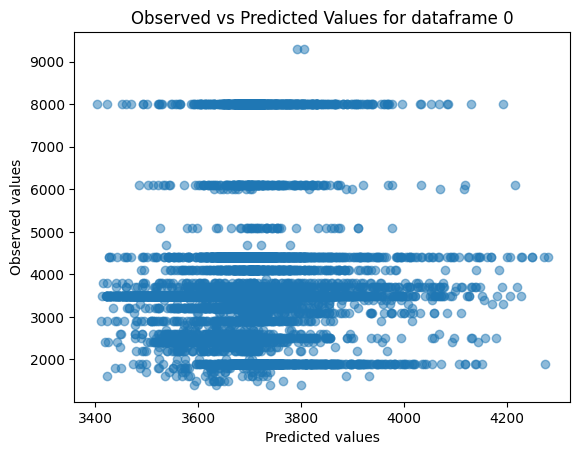

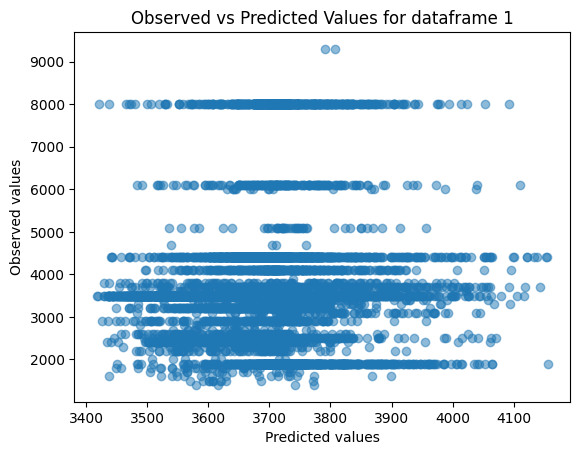

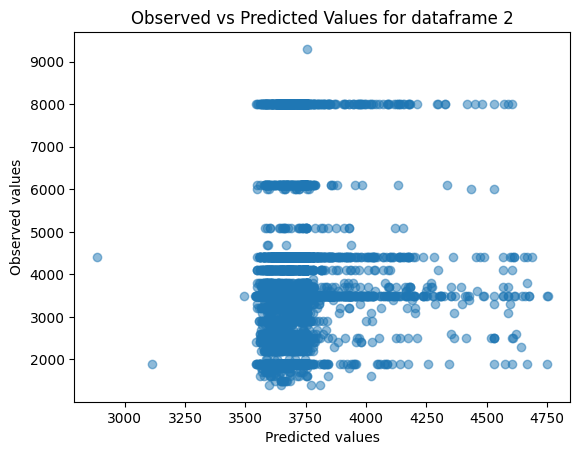

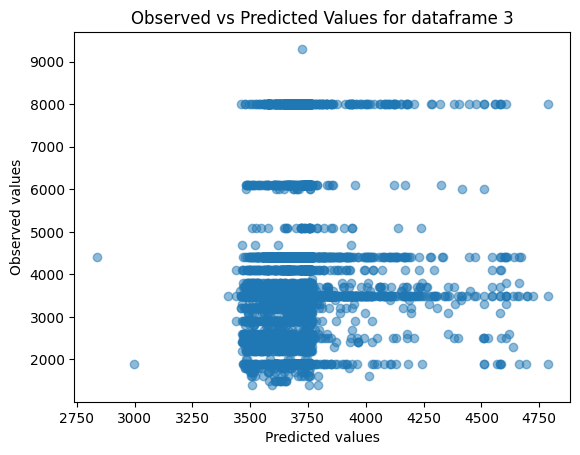

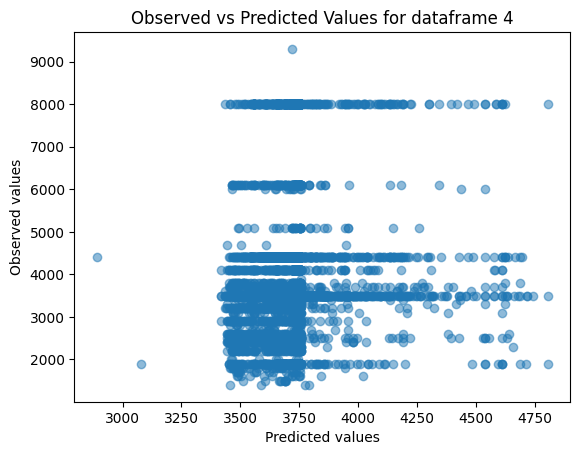

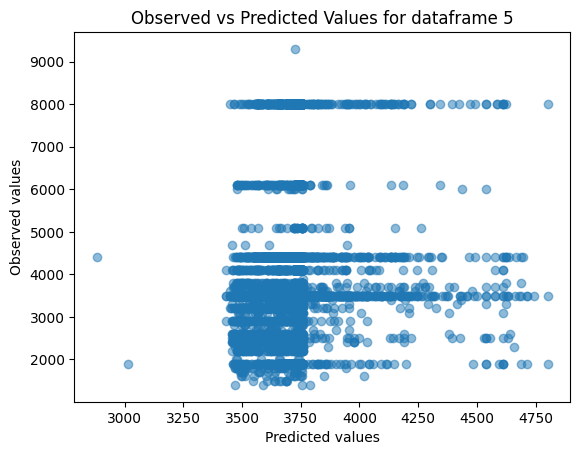

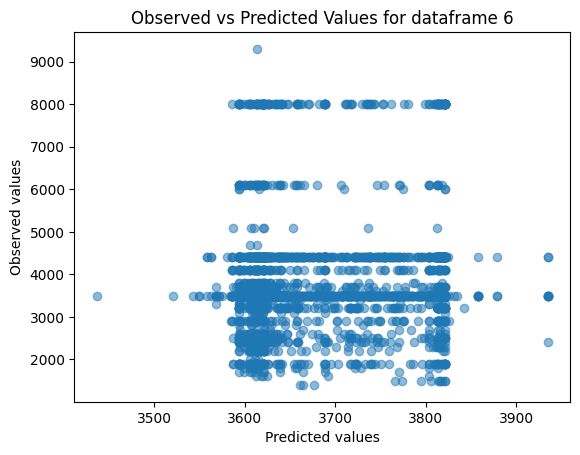

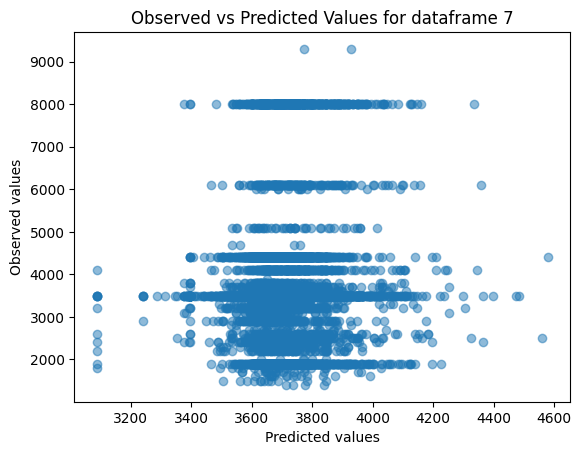

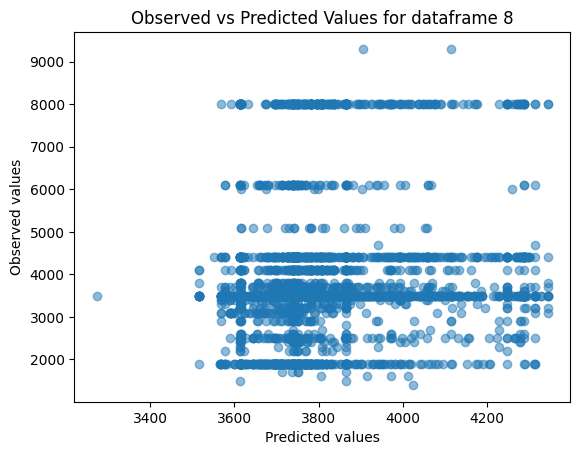

In [11]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

for i, df in enumerate(dfs):
    # Fit an initial OLS model
    X = sm.add_constant(df[predictors])  # Adding the intercept term
    y = df[outcome]
    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate predicted values
    df['predicted'] = results.fittedvalues

    # Plot observed vs predicted values
    plt.figure(i)
    plt.scatter(df['predicted'], y, alpha=0.5)
    plt.xlabel('Predicted values')
    plt.ylabel('Observed values')
    plt.title(f'Observed vs Predicted Values for dataframe {i}')
    plt.show()

In [13]:
import statsmodels.api as sm

# Assume you have fitted a model and have the results
# model = sm.OLS(y, X)
# results = model.fit()

# Now you can use the help function to get information about the methods
#help(results.get_influence)
import statsmodels.stats.outliers_influence as oi
help(oi.OLSInfluence)

Help on class OLSInfluence in module statsmodels.stats.outliers_influence:

class OLSInfluence(_BaseInfluenceMixin)
 |  OLSInfluence(results)
 |  
 |  class to calculate outlier and influence measures for OLS result
 |  
 |  Parameters
 |  ----------
 |  results : RegressionResults
 |      currently assumes the results are from an OLS regression
 |  
 |  Notes
 |  -----
 |  One part of the results can be calculated without any auxiliary regression
 |  (some of which have the `_internal` postfix in the name. Other statistics
 |  require leave-one-observation-out (LOOO) auxiliary regression, and will be
 |  slower (mainly results with `_external` postfix in the name).
 |  The auxiliary LOOO regression only the required results are stored.
 |  
 |  Using the LOO measures is currently only recommended if the data set
 |  is not too large. One possible approach for LOOO measures would be to
 |  identify possible problem observations with the _internal measures, and
 |  then run the leave-on

In [9]:
results.get_influence().resid_studentized_internal

array([-1.2330899 ,  0.38437938, -1.03964731, ..., -1.22385734,
       -0.31354896, -1.34996412])

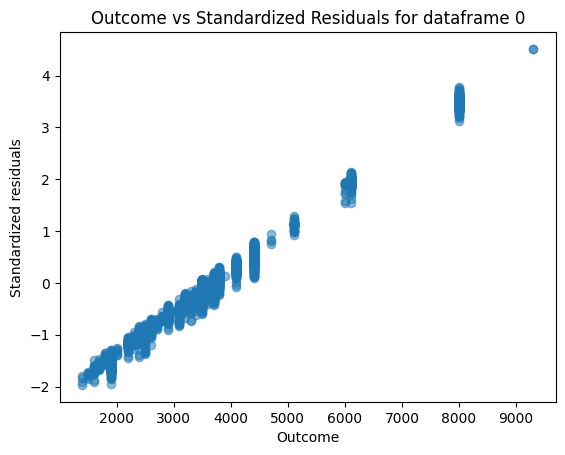

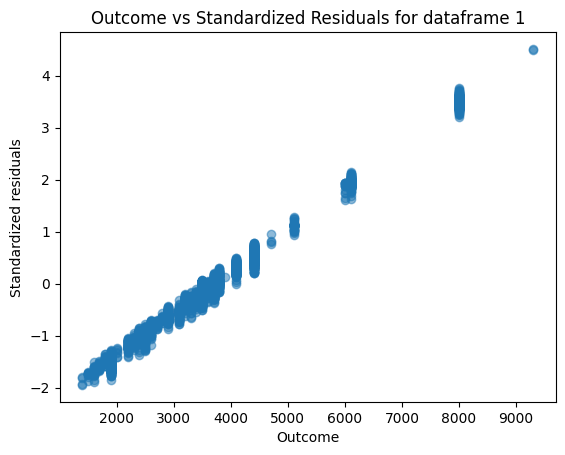

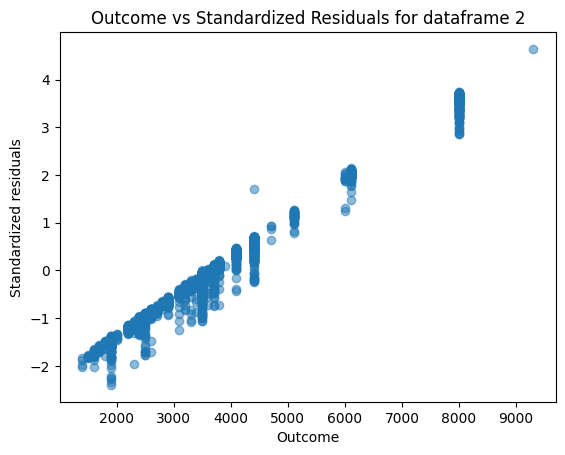

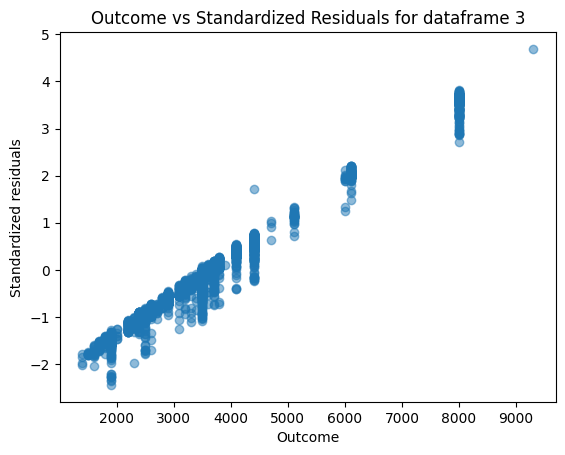

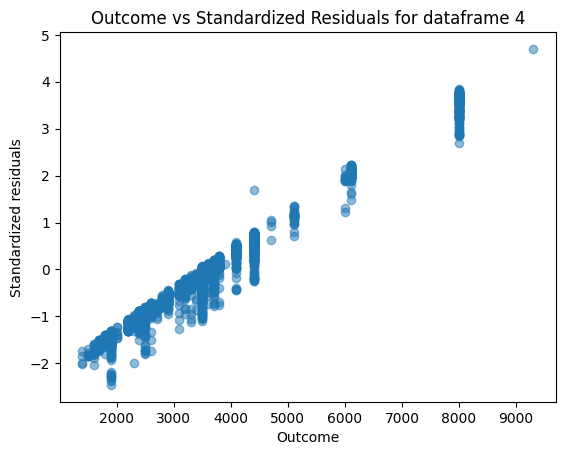

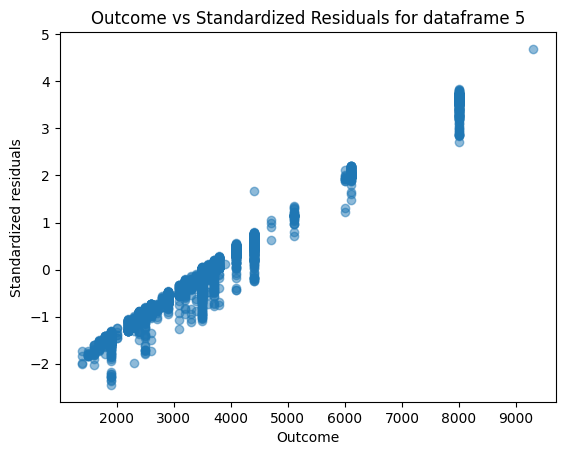

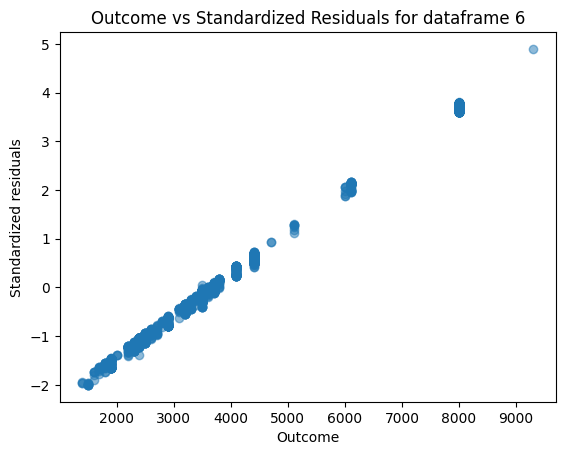

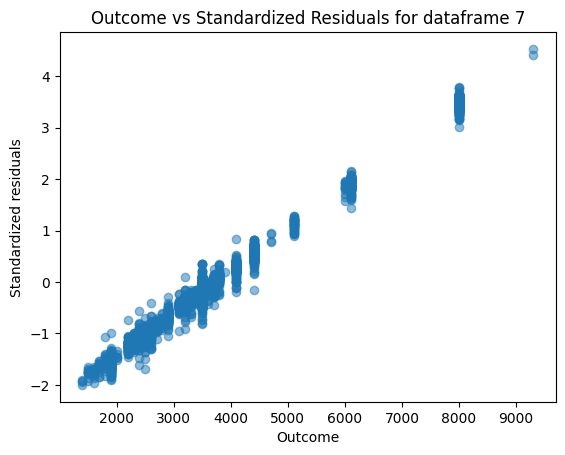

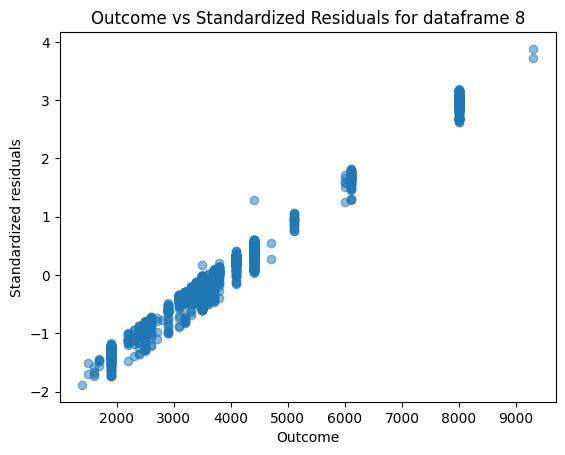

In [10]:
import matplotlib.pyplot as plt
outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']


for i, df in enumerate(dfs):
    # Fit an initial OLS model
    X = sm.add_constant(df[predictors])  # Adding the intercept term
    y = df[outcome]
    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate standardized residuals
    df['std_residuals'] = results.get_influence().resid_studentized_internal #regression model residual divided by its adjusted standard error

    # Plot standardized residuals vs outcome
    plt.figure(i)
    plt.scatter(y,df['std_residuals'], alpha=0.5)
    plt.xlabel('Outcome')
    plt.ylabel('Standardized residuals')
    plt.title(f'Outcome vs Standardized Residuals for dataframe {i}')
    plt.show()

There is a linear relationship etween the residuals and the outcome variables. Tghis suggests that the model is misspecified. 

#### 2. Homoscedasticity - equal variance (Violated)

Homoscedasticity means that the error doesn’t doesn’t change across all the values of the independent variable.


In [19]:
help(sm.OLS)

Help on class OLS in module statsmodels.regression.linear_model:

class OLS(WLS)
 |  OLS(endog, exog=None, missing='none', hasconst=None, **kwargs)
 |  
 |  Ordinary Least Squares
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      A 1-d endogenous response variable. The dependent variable.
 |  exog : array_like
 |      A nobs x k array where `nobs` is the number of observations and `k`
 |      is the number of regressors. An intercept is not included by default
 |      and should be added by the user. See
 |      :func:`statsmodels.tools.add_constant`.
 |  missing : str
 |      Available options are 'none', 'drop', and 'raise'. If 'none', no nan
 |      checking is done. If 'drop', any observations with nans are dropped.
 |      If 'raise', an error is raised. Default is 'none'.
 |  hasconst : None or bool
 |      Indicates whether the RHS includes a user-supplied constant. If True,
 |      a constant is not checked for and k_constant is set to 1 and all
 |      result s

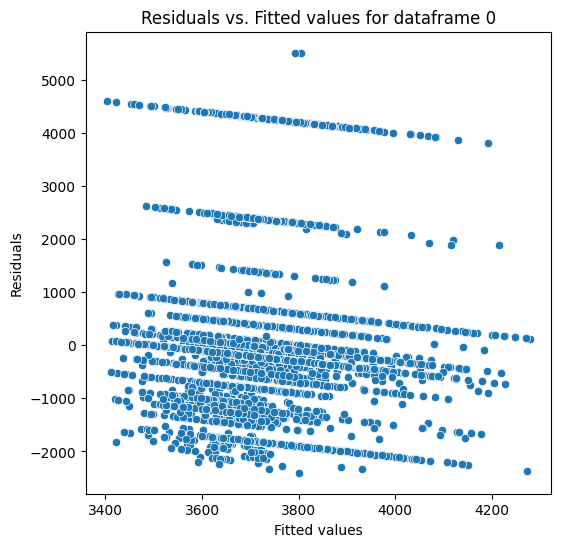

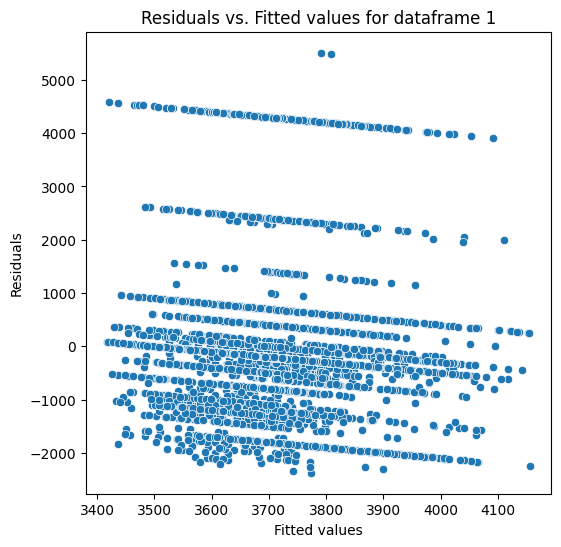

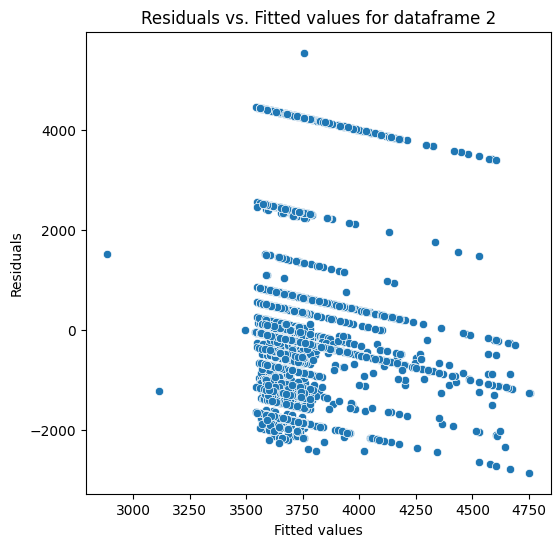

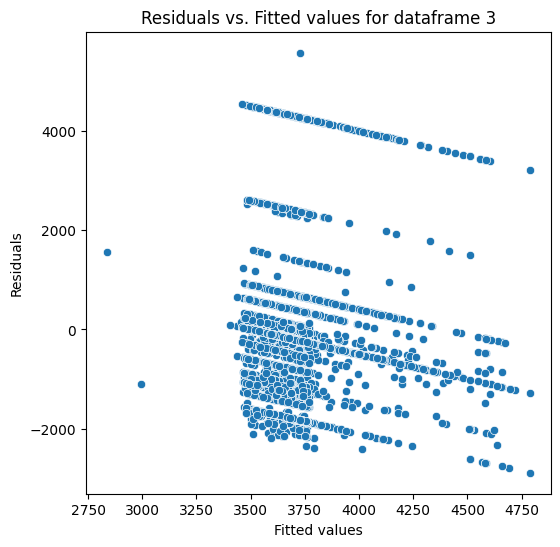

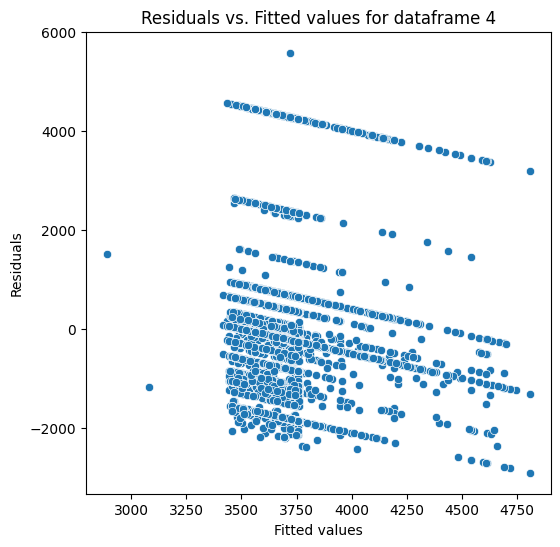

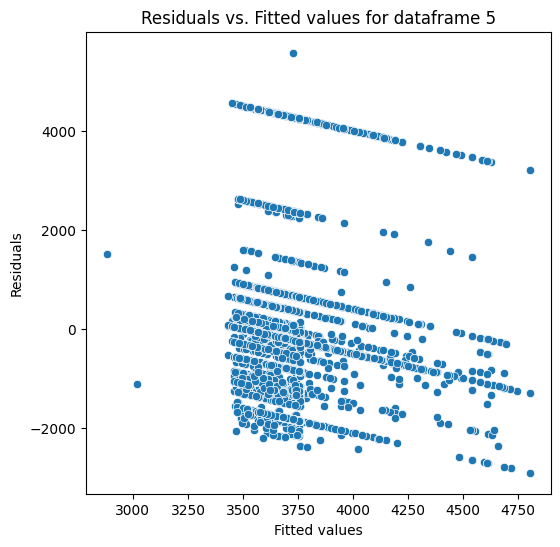

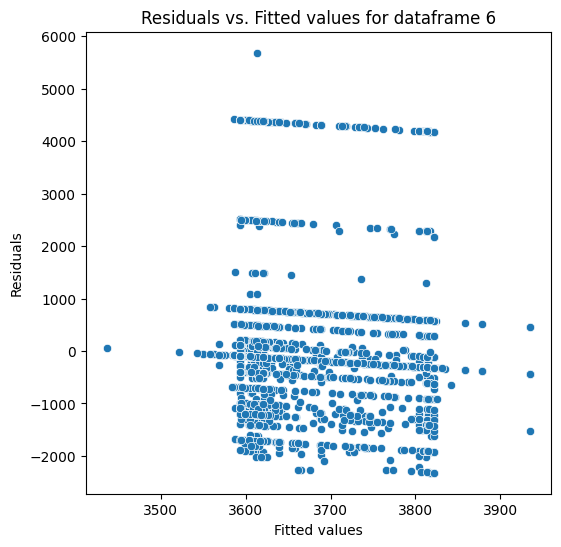

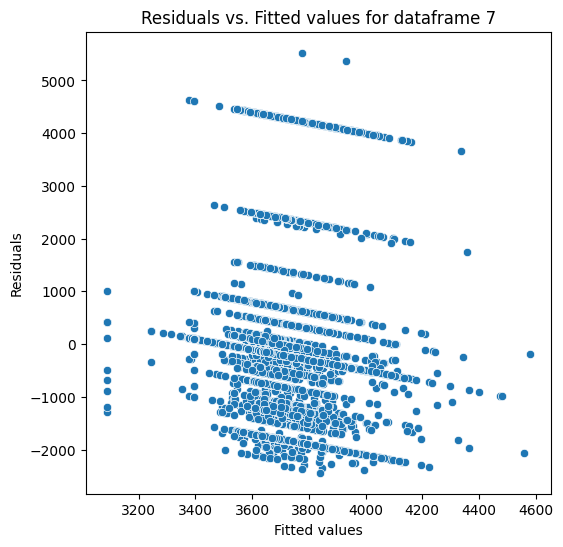

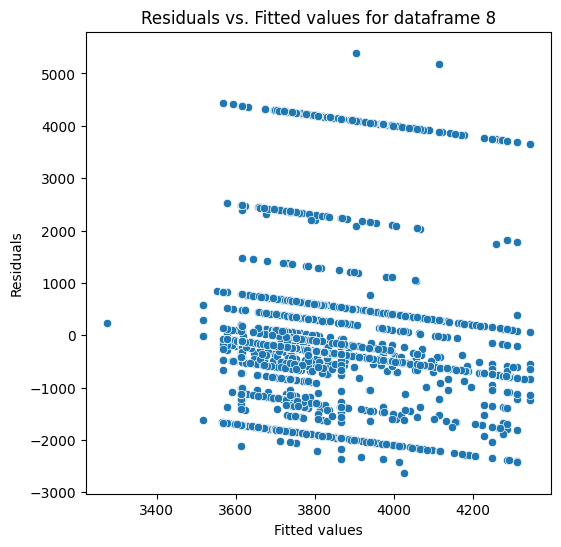

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Loop over all dataframes
for i, df in enumerate(dfs):
    # Define dependent and independent variables
    X = df[predictors]
    X = sm.add_constant(X)  # Adding the intercept term
    y = df[outcome]

    # Fit the model
    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate predictions and residuals
    predictions = results.predict(X)
    residuals = y - predictions

    # Create the plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=predictions, y=residuals)
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted values for dataframe {i}')
    plt.show()

The White test

In [122]:
#Importing Libraries
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip



# The outcome variable
y = 'Salaire_moyen_en_EQTP'

# The predictor variables
x = ['0', '1', '2']

# Loop over dataframes in dfs
for i, df in enumerate(dfs):
    # Fit the model
    model = sm.OLS(df[y], sm.add_constant(df[x])).fit()

    # Perform White's test
    white_test = het_white(model.resid, model.model.exog)

    # Print the results
    print(f"White's test results for dataframe {i+1}:")
    print(lzip(['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'], white_test))
    print()

White's test results for dataframe 1:
[('Lagrange multiplier statistic', 142.9356216736284), ('p-value', 2.553609841079466e-26), ('f-value', 16.064764491489953), ('f p-value', 1.7434778558574117e-26)]

White's test results for dataframe 2:
[('Lagrange multiplier statistic', 169.33524315303688), ('p-value', 8.487802103583439e-32), ('f-value', 19.07554007226158), ('f p-value', 4.901443820100754e-32)]

White's test results for dataframe 3:
[('Lagrange multiplier statistic', 86.53705872570015), ('p-value', 8.042584577684568e-15), ('f-value', 9.682921690859564), ('f p-value', 7.030667185721706e-15)]

White's test results for dataframe 4:
[('Lagrange multiplier statistic', 98.69427810324798), ('p-value', 2.889623766193296e-17), ('f-value', 11.057941323280629), ('f p-value', 2.400593494573087e-17)]

White's test results for dataframe 5:
[('Lagrange multiplier statistic', 107.08604618463896), ('p-value', 5.756433823896669e-19), ('f-value', 12.008320498559304), ('f p-value', 4.603397995825392e-

The White Test has the null hypothesis that the errors are have same variance or homoscedastic. Having a p-value ≤ 0.05 would indicate that the null hypothesis is rejected, hence Heteroscedasticity

Here, only model 7 meets the assumption with p being greater than .05.


Solutions to lack of homoscedasticity:

- Outlier removal
- Log transformation of x variables
- Polynomial regresion


Alternatively - drop OLS and instead use:
- Weighted Least Squares (WLS) 
- Generalized Least Squares (GLS) 

### 3) Errors are normally distributed (Violated)

<Figure size 800x600 with 0 Axes>

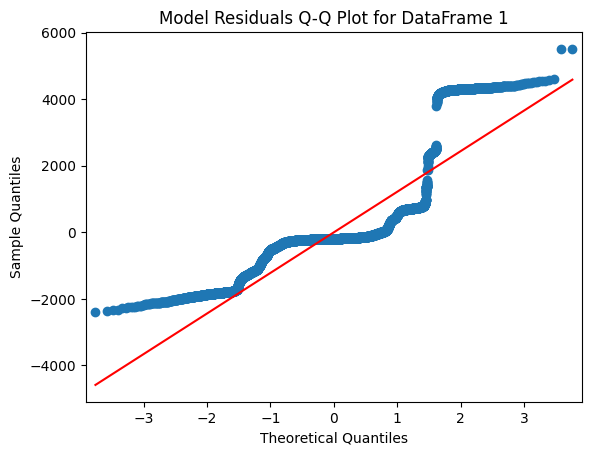

<Figure size 800x600 with 0 Axes>

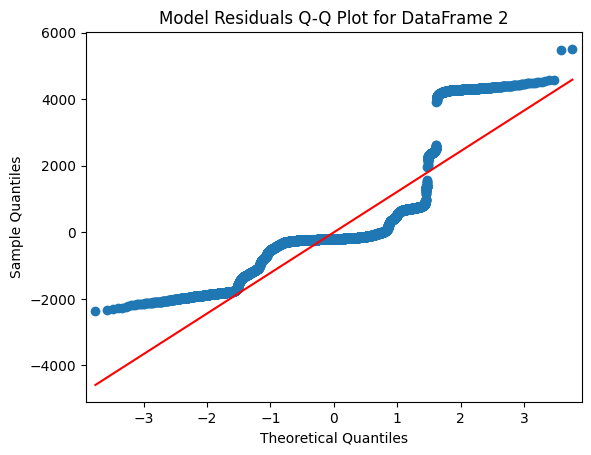

<Figure size 800x600 with 0 Axes>

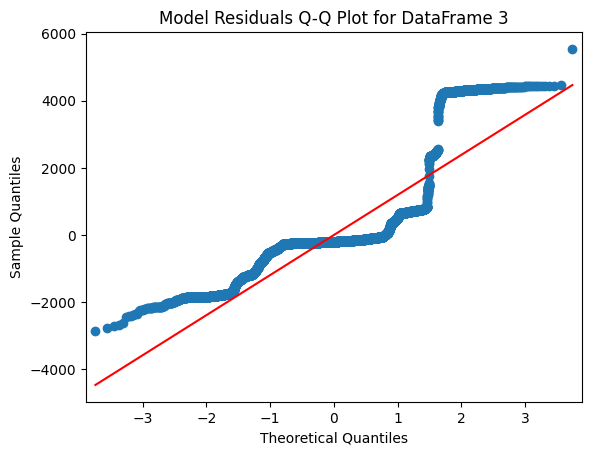

<Figure size 800x600 with 0 Axes>

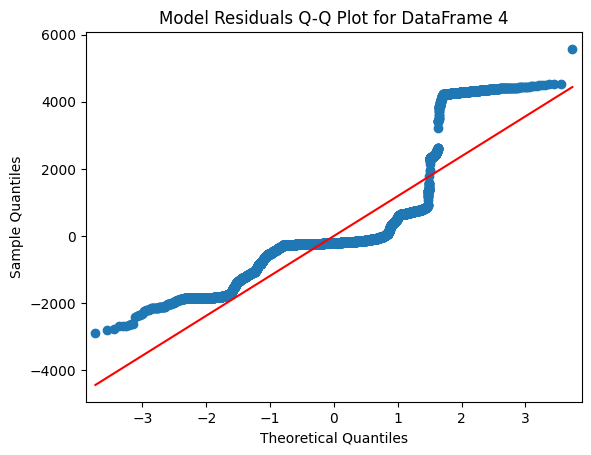

<Figure size 800x600 with 0 Axes>

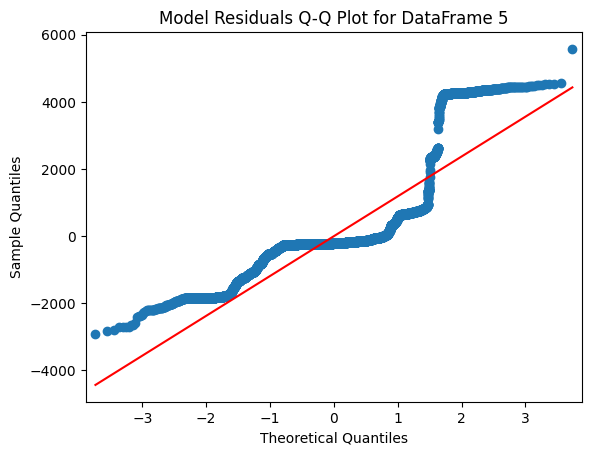

<Figure size 800x600 with 0 Axes>

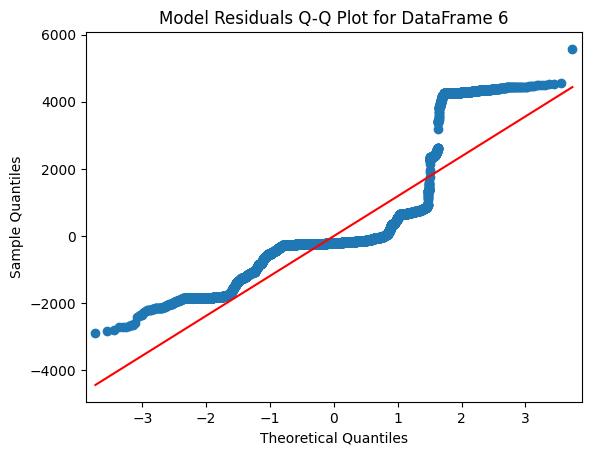

<Figure size 800x600 with 0 Axes>

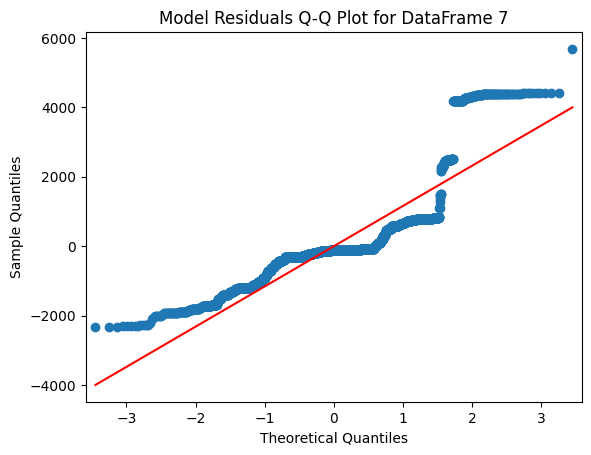

<Figure size 800x600 with 0 Axes>

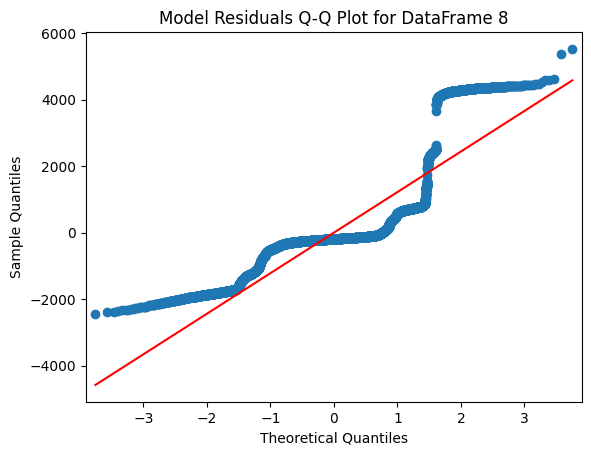

<Figure size 800x600 with 0 Axes>

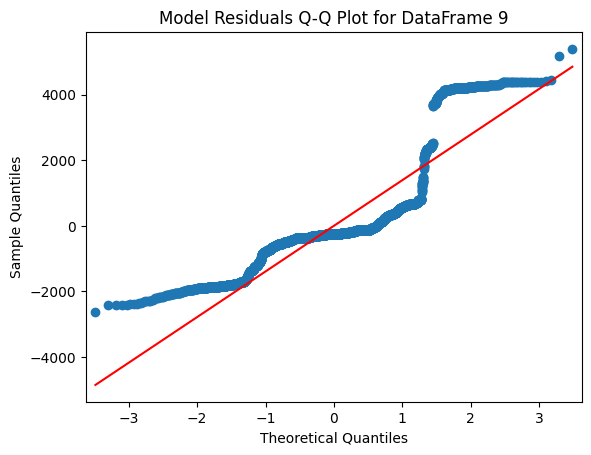

In [142]:
#Import library
from scipy import stats


outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']


for i, df in enumerate(dfs):
    # Fit a linear regression model
    X = sm.add_constant(df[predictors])  # Adding the intercept term
    y = df[outcome]
    model = sm.OLS(y, X)
    results = model.fit()

    # Create QQ plot
    plt.figure(figsize=(8, 6))  # Adjust the figure size
    sm.qqplot(results.resid, line='s')
    plt.title(f'Model Residuals Q-Q Plot for DataFrame {i+1}')
    plt.show()

### 4) Independent observations - no autocorrelatiions ***

Yes, because:
Being a factor analysis method spatialisation assures non linear dependence between spatialisation along CA dimensions. At least for the first N. That’s another why I think taking N=3 is a good bet.

### 5) No multicolinearity - Predictors are not correlated with each other ***

Below: Across all models, the predictors are not highly correlated.

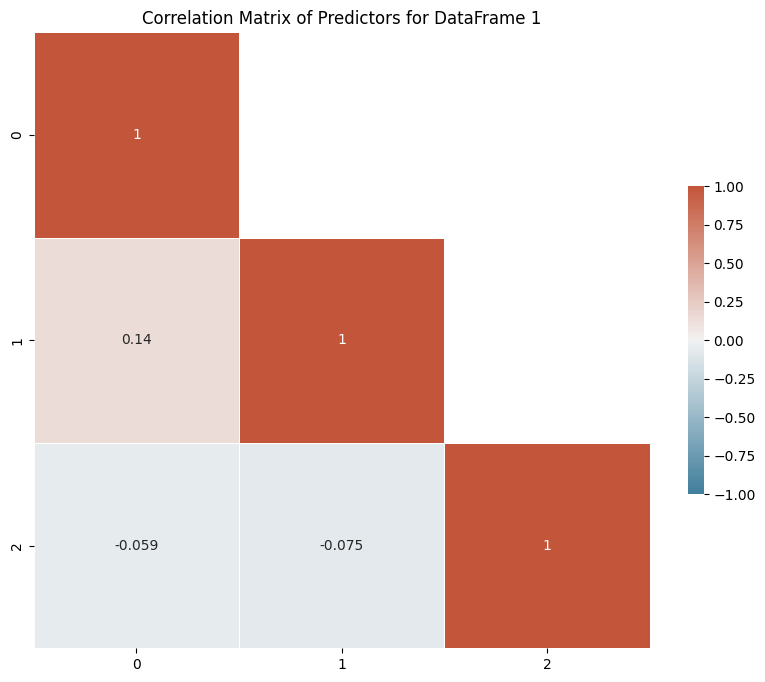

   VIF Factor features
0    1.051850        0
1    1.051903        1
2    1.000238        2
Model 1 does not have high multicollinearity


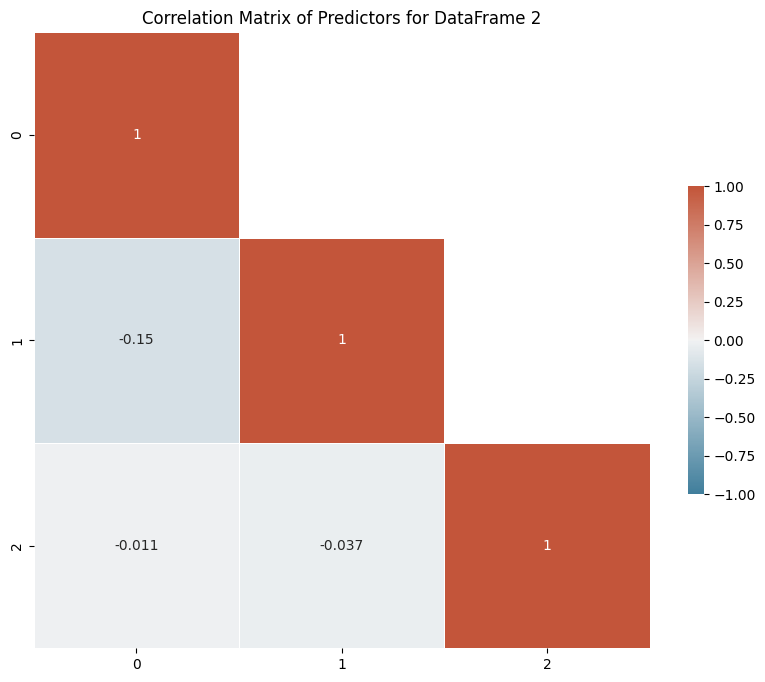

   VIF Factor features
0    1.077681        0
1    1.067753        1
2    1.032557        2
Model 2 does not have high multicollinearity


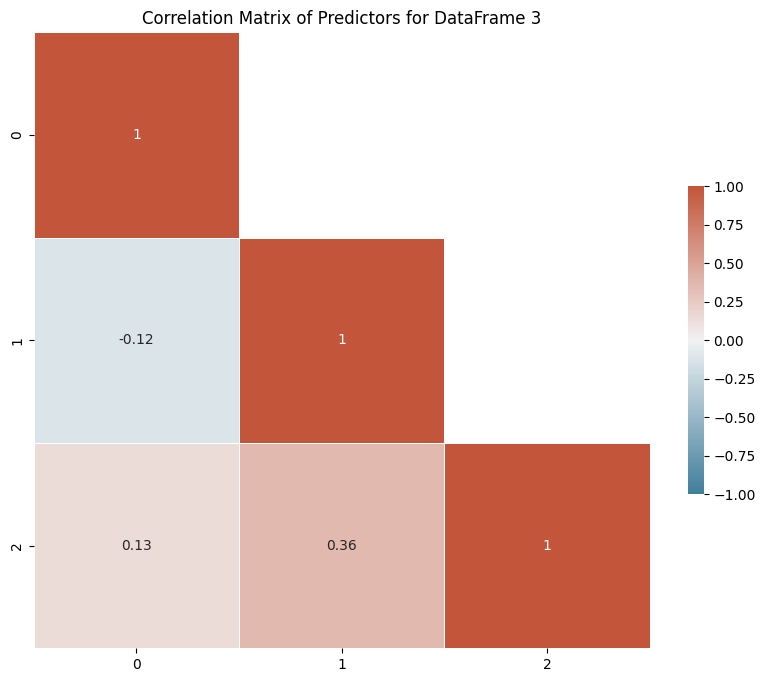

   VIF Factor features
0    1.156443        0
1    1.213515        1
2    1.198152        2
Model 3 does not have high multicollinearity


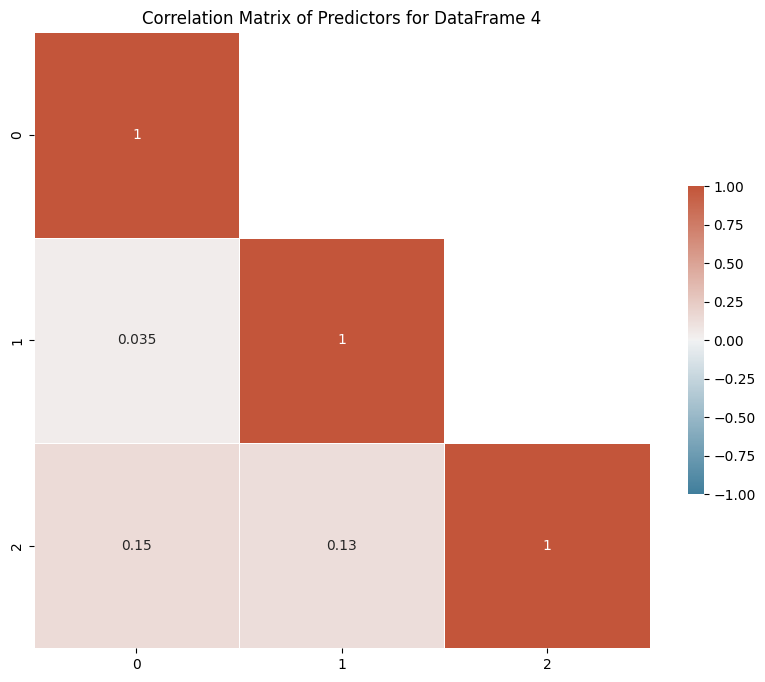

   VIF Factor features
0    1.158977        0
1    1.008447        1
2    1.162653        2
Model 4 does not have high multicollinearity


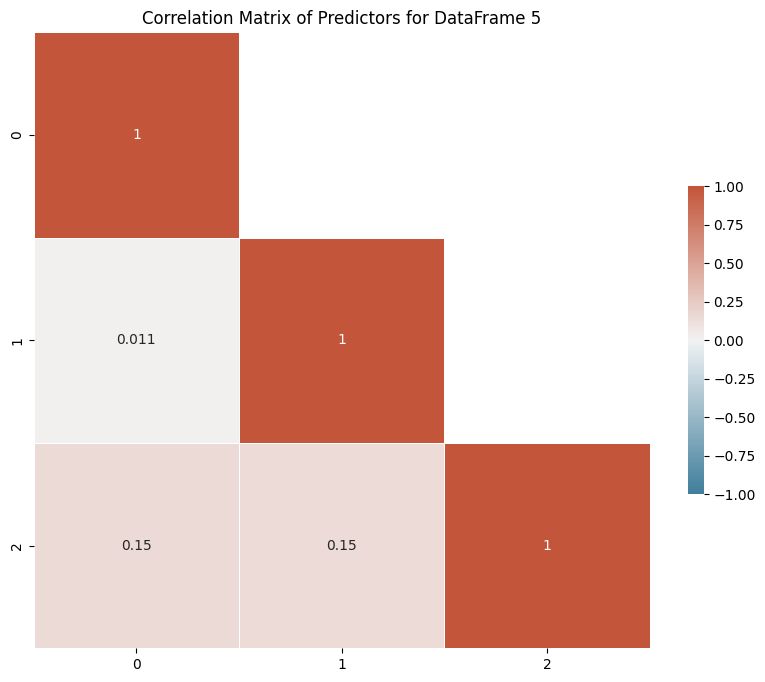

   VIF Factor features
0    1.186866        0
1    1.015264        1
2    1.182868        2
Model 5 does not have high multicollinearity


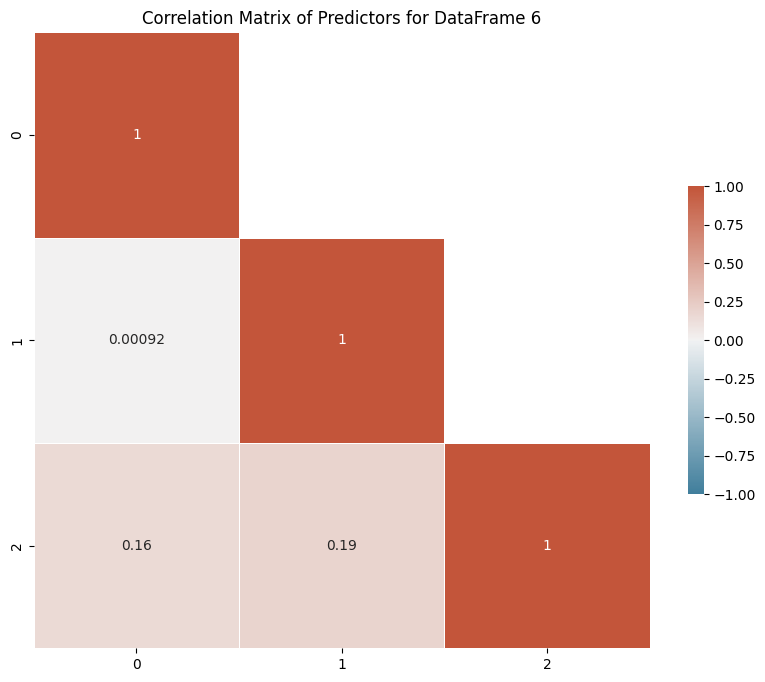

   VIF Factor features
0    1.197252        0
1    1.030261        1
2    1.189551        2
Model 6 does not have high multicollinearity


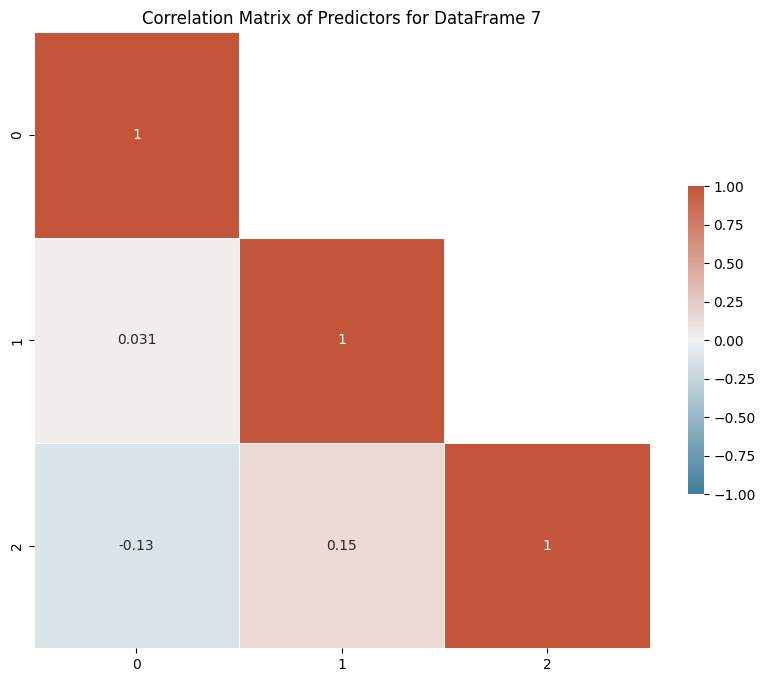

   VIF Factor features
0    1.013245        0
1    1.026275        1
2    1.036007        2
Model 7 does not have high multicollinearity


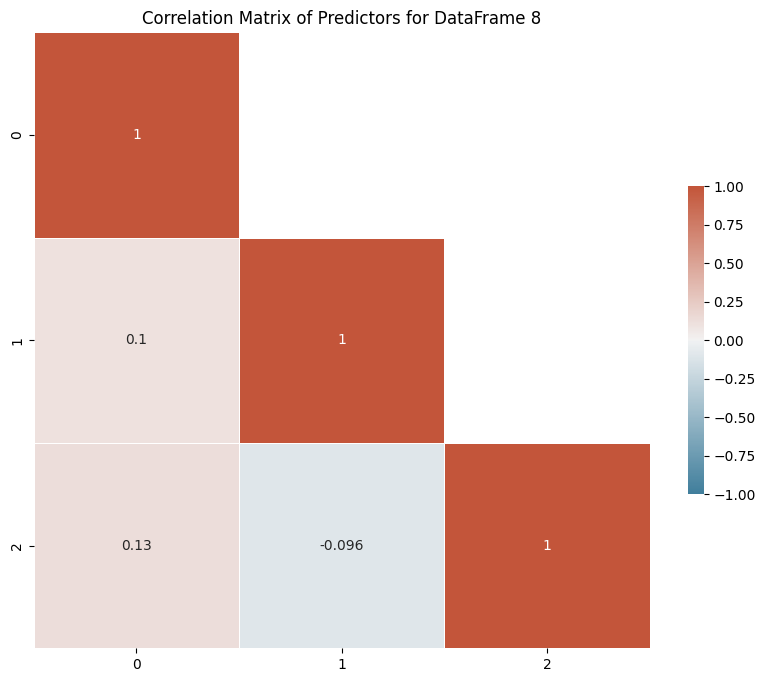

   VIF Factor features
0    1.039742        0
1    1.023754        1
2    1.046311        2
Model 8 does not have high multicollinearity


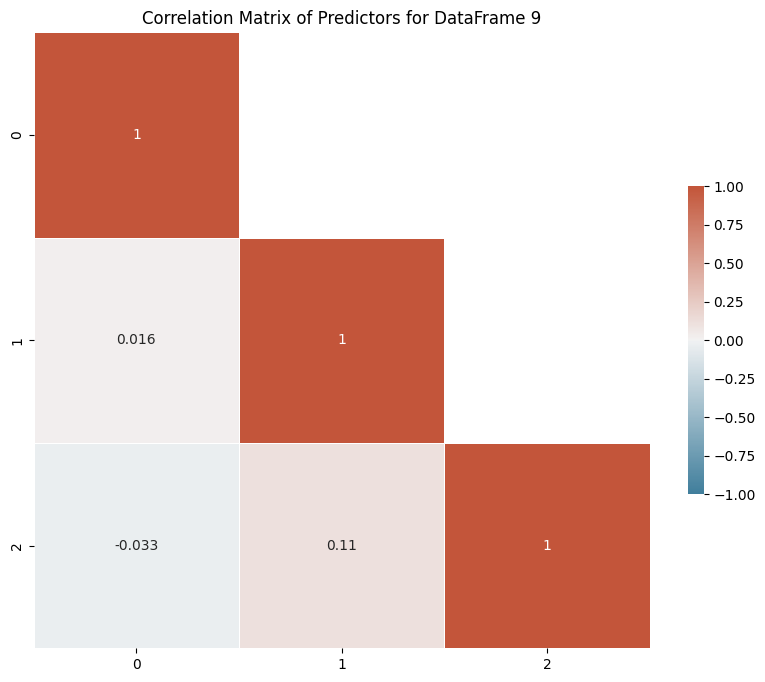

   VIF Factor features
0    1.001291        0
1    1.013552        1
2    1.014629        2
Model 9 does not have high multicollinearity


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Loop over dataframes in dfs
for i, df in enumerate(dfs):
    # Calculate the correlation matrix
    corr_matrix = df[predictors].corr()

    # Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
    # top-left to bottom-right diagonal)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # k=1 keeps the main diagonal unmasked

    # Create a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1,  # Set color range from -1 to 1
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

    plt.title(f'Correlation Matrix of Predictors for DataFrame {i+1}')
    plt.show()

    # Calculate VIF for each predictor
    X = df[predictors]
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, j) for j in range(X.shape[1])]
    vif["features"] = X.columns

    print(vif)

    # Check if there's high multicollinearity
    if vif["VIF Factor"].max() > 5:
        print(f'Model {i+1} might have high multicollinearity')
    else:
        print(f'Model {i+1} does not have high multicollinearity')

### 6) Outlier check

/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


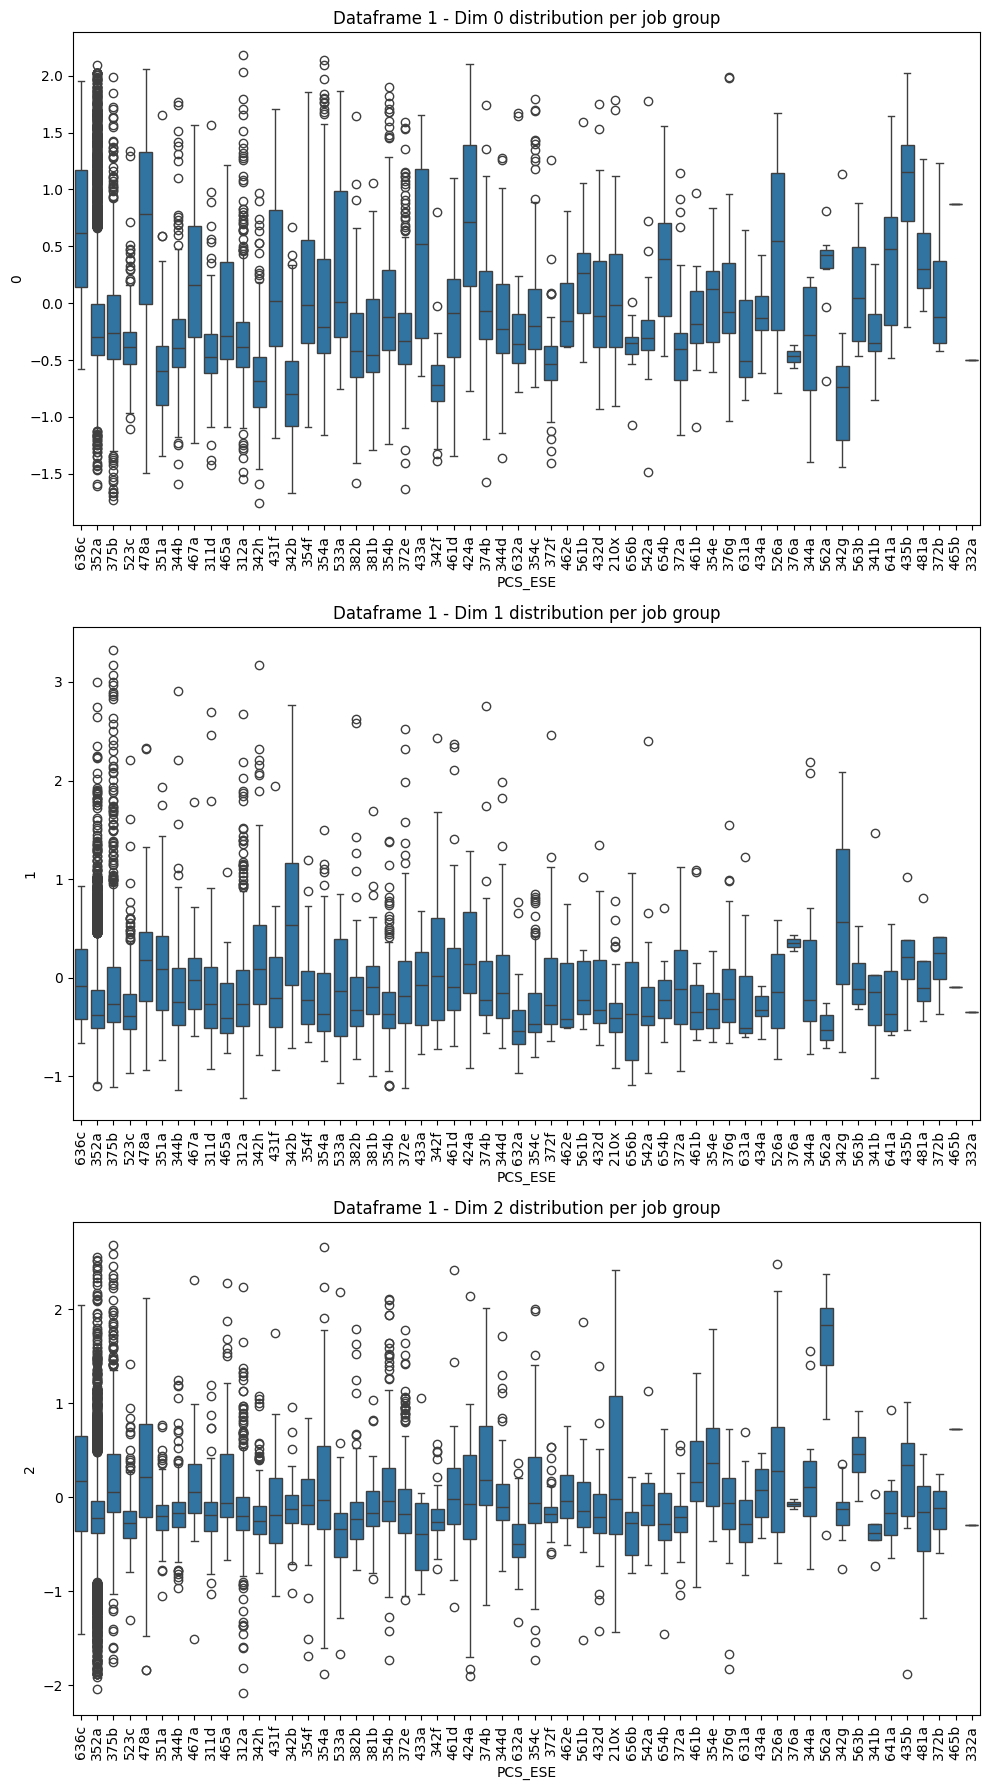

/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


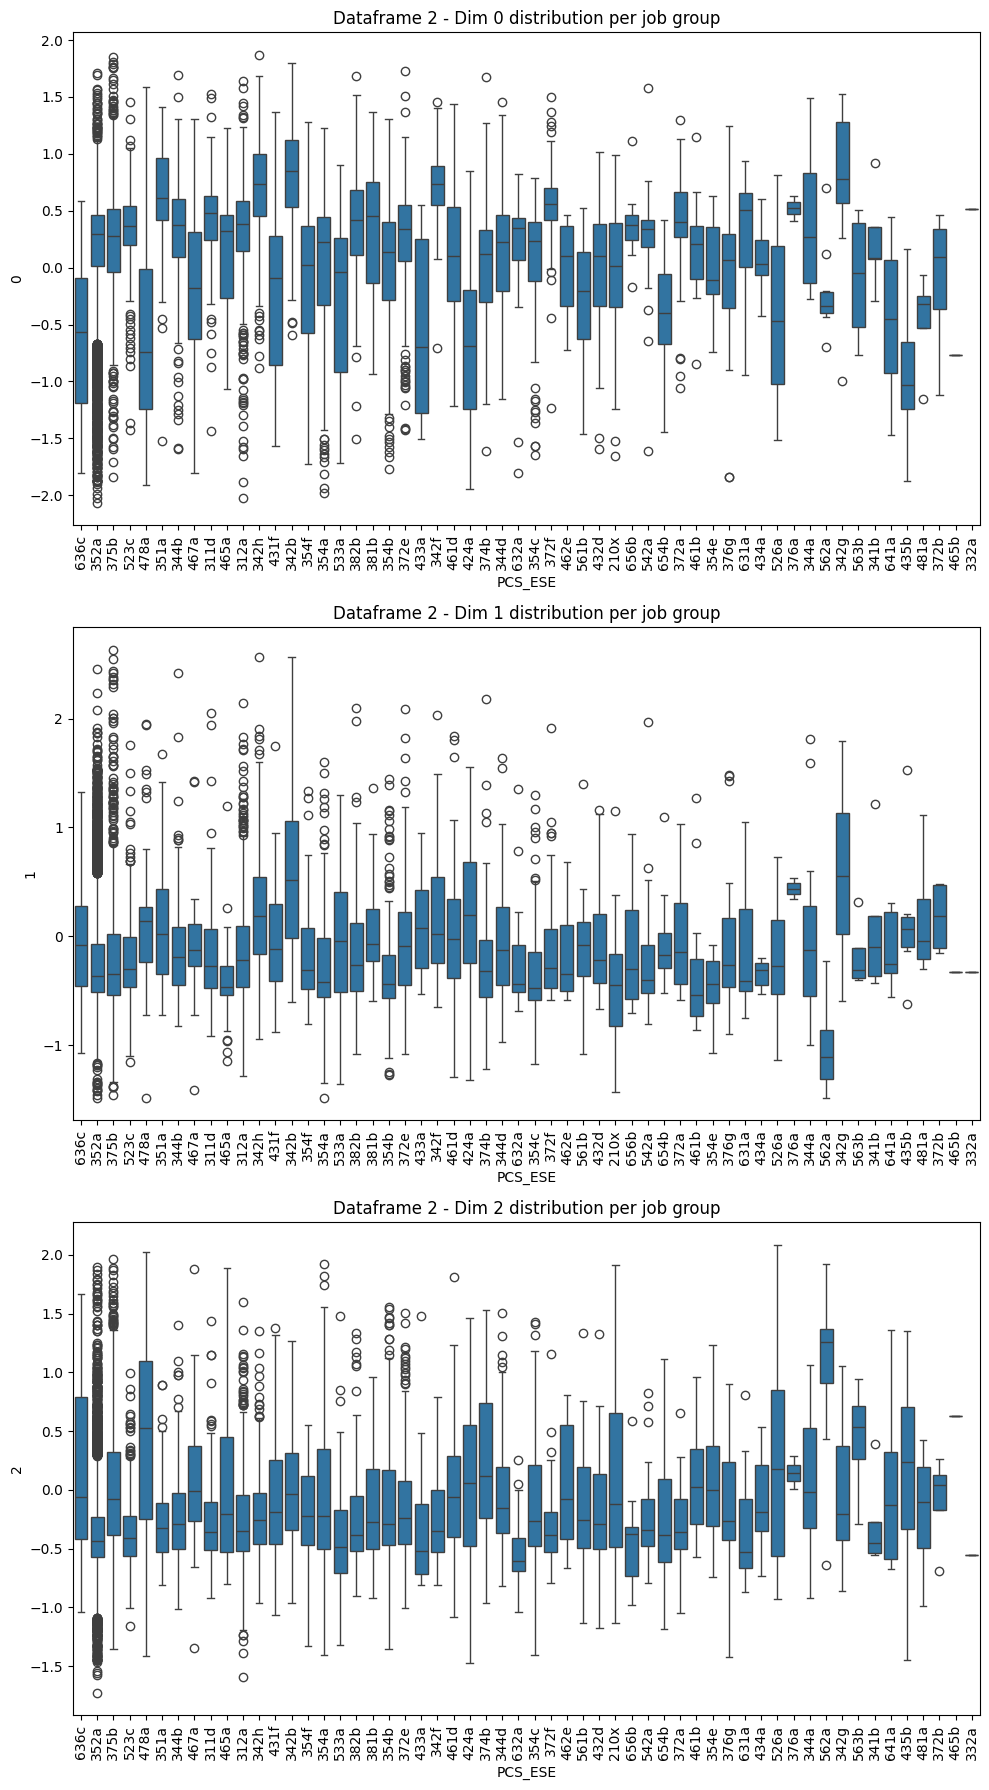

/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


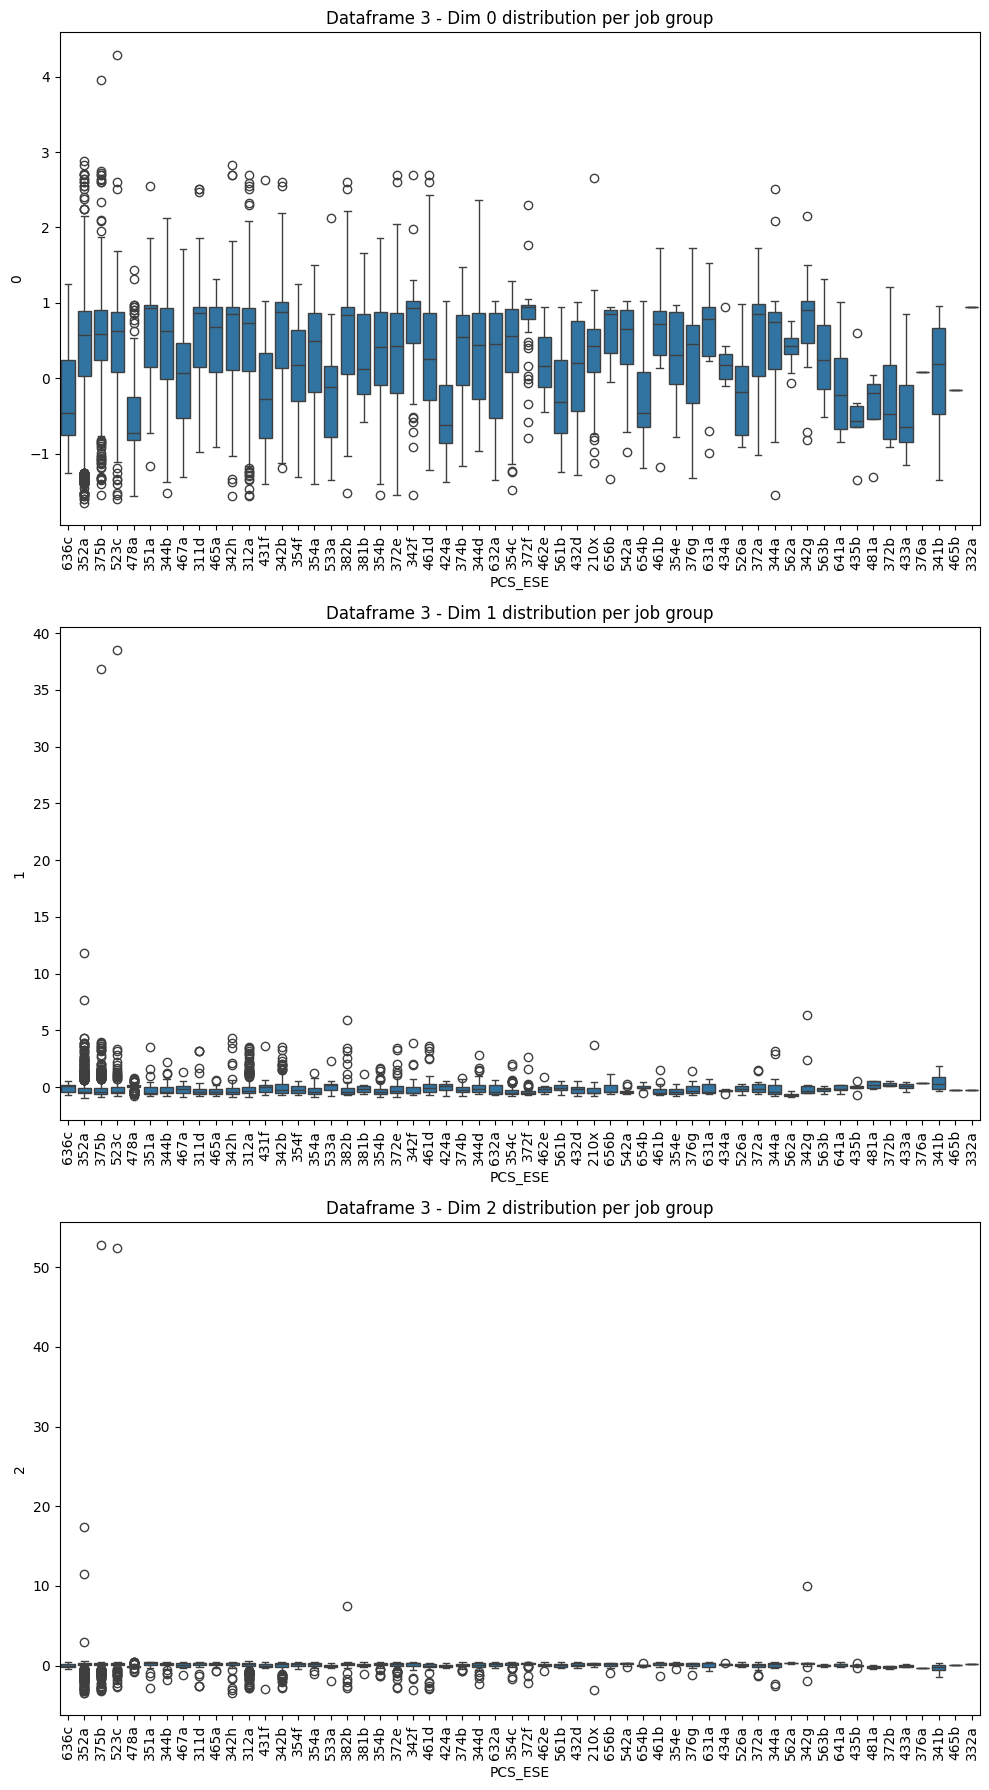

/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


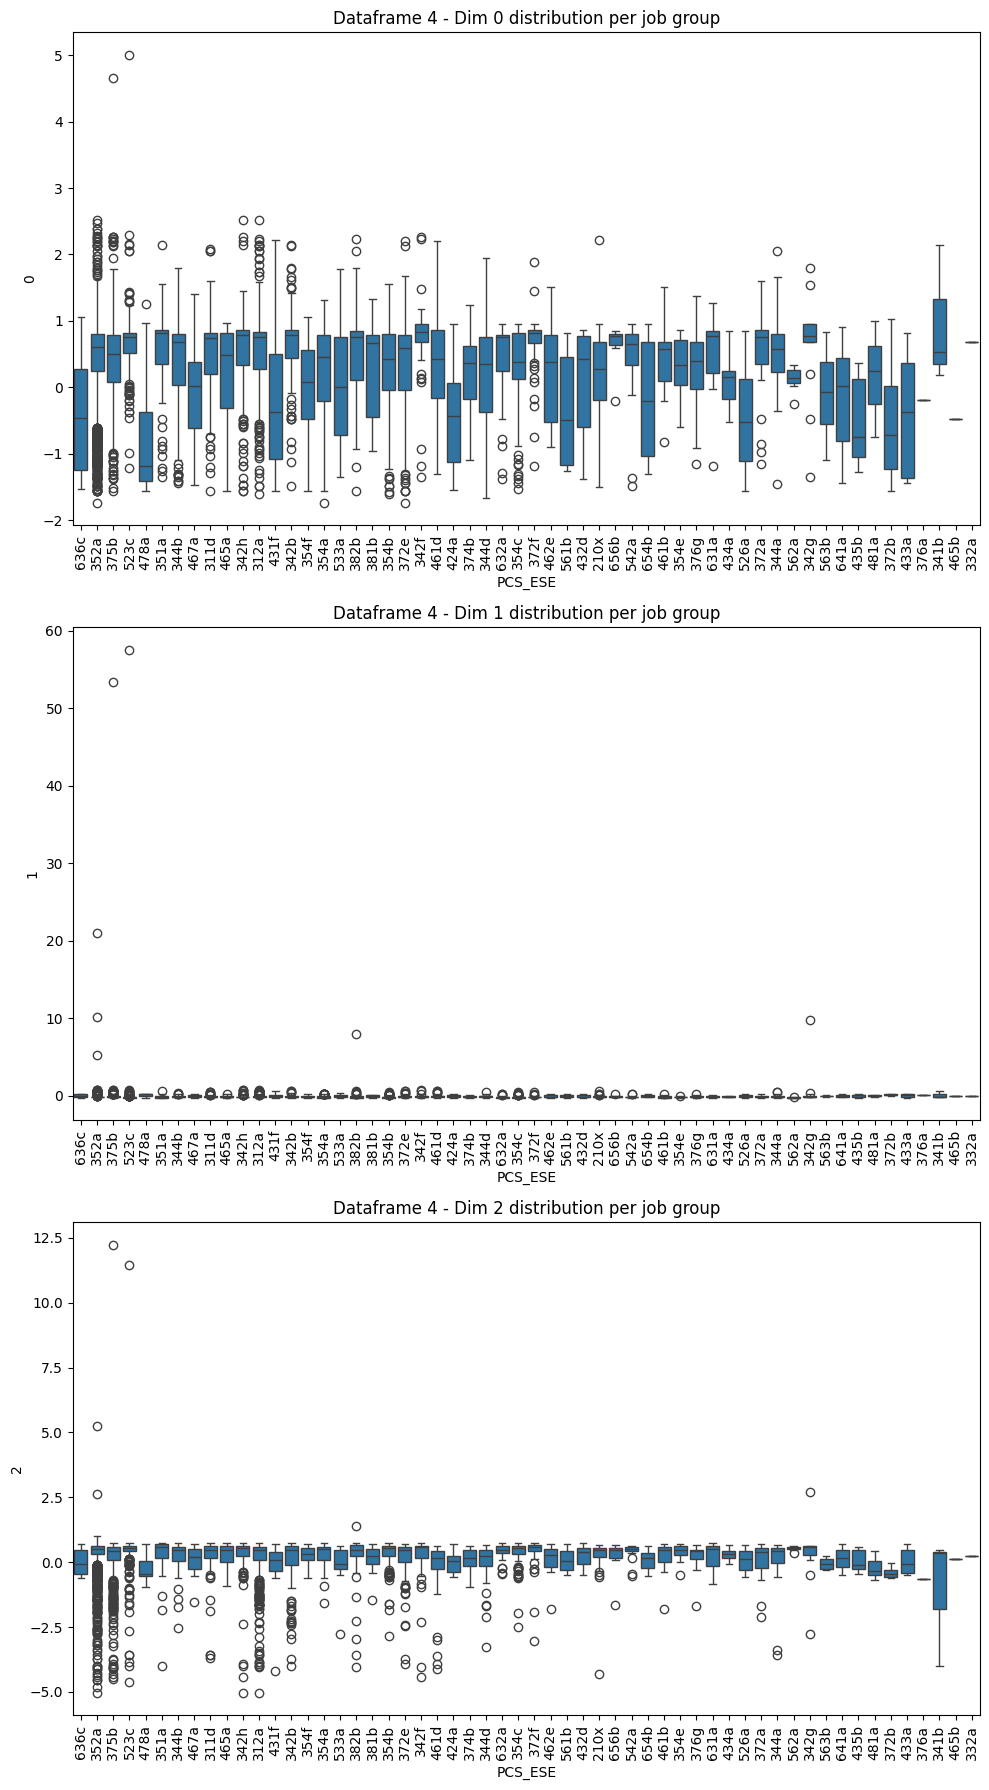

/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


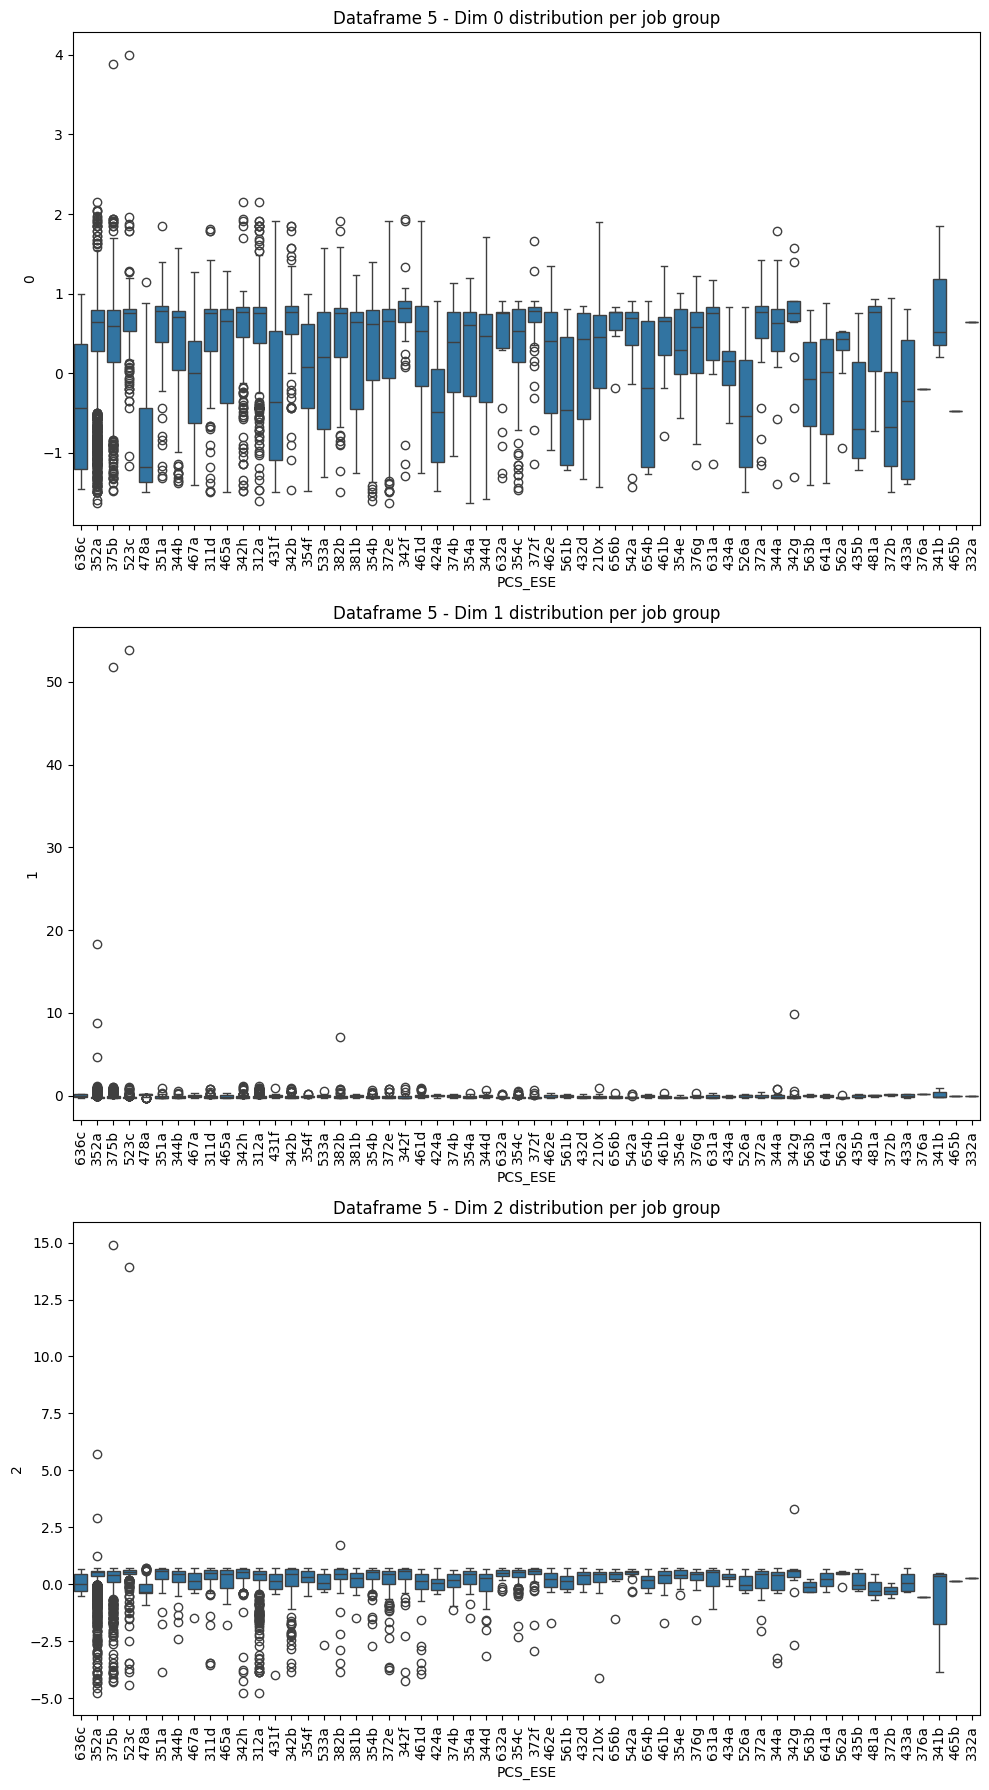

/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


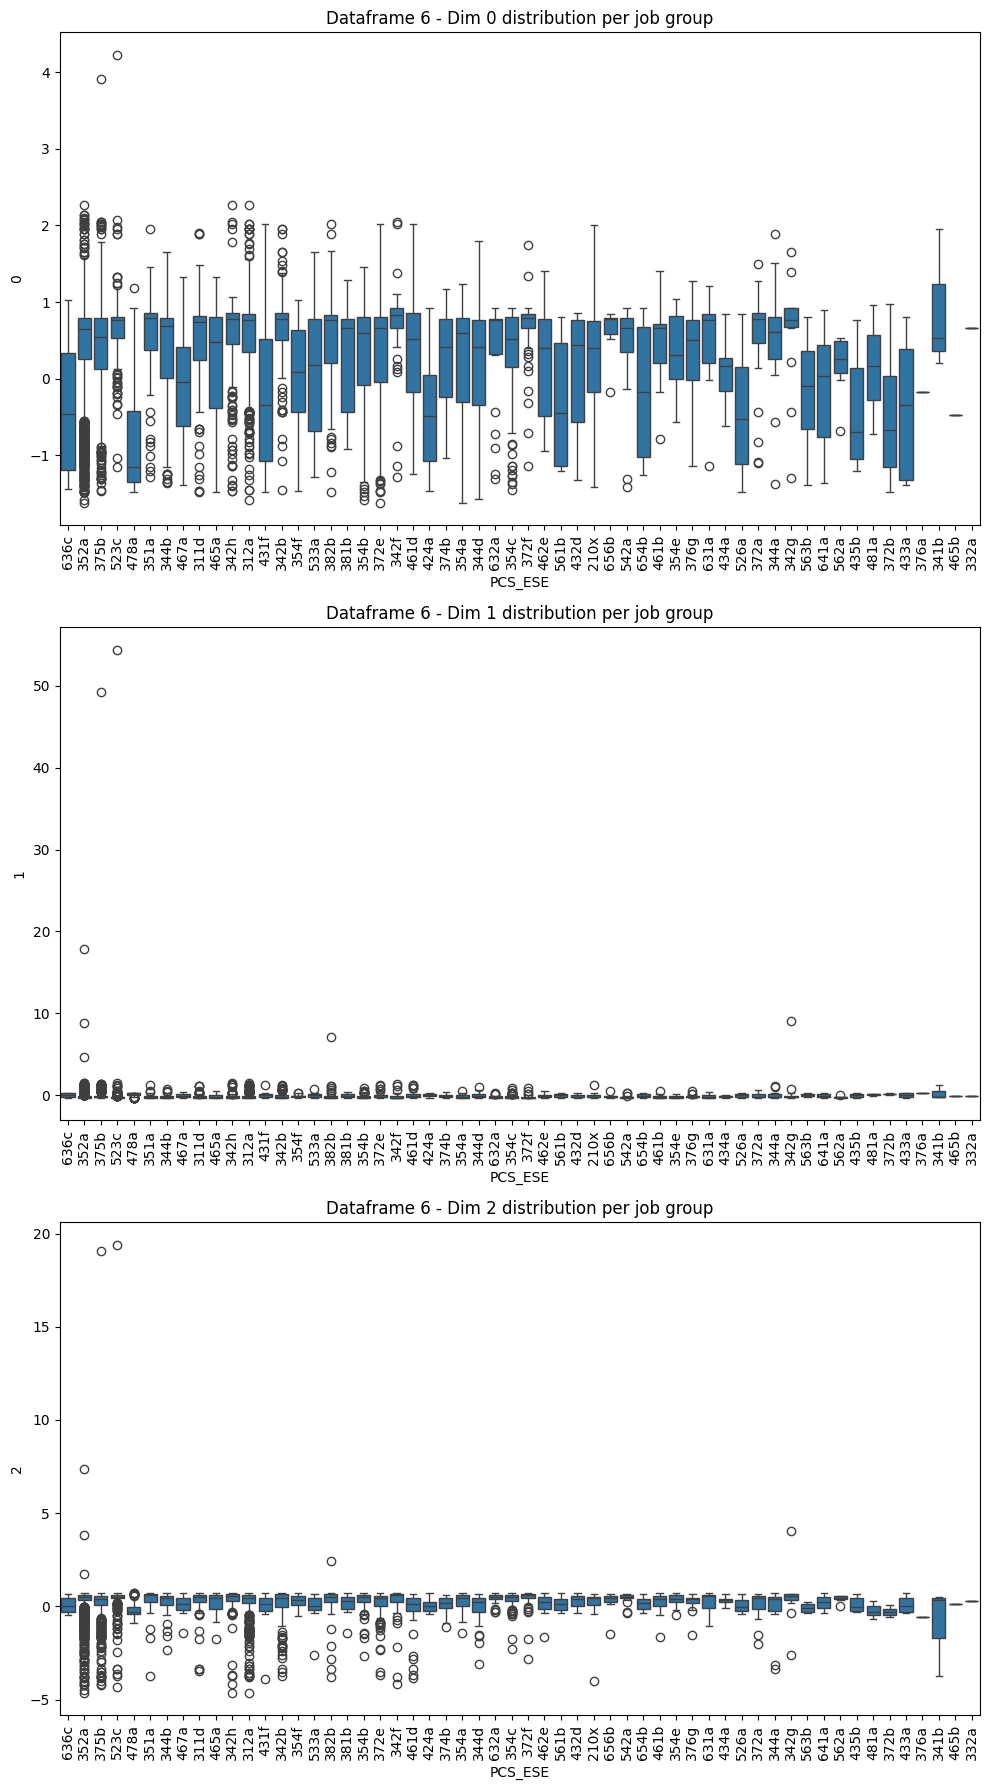

/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


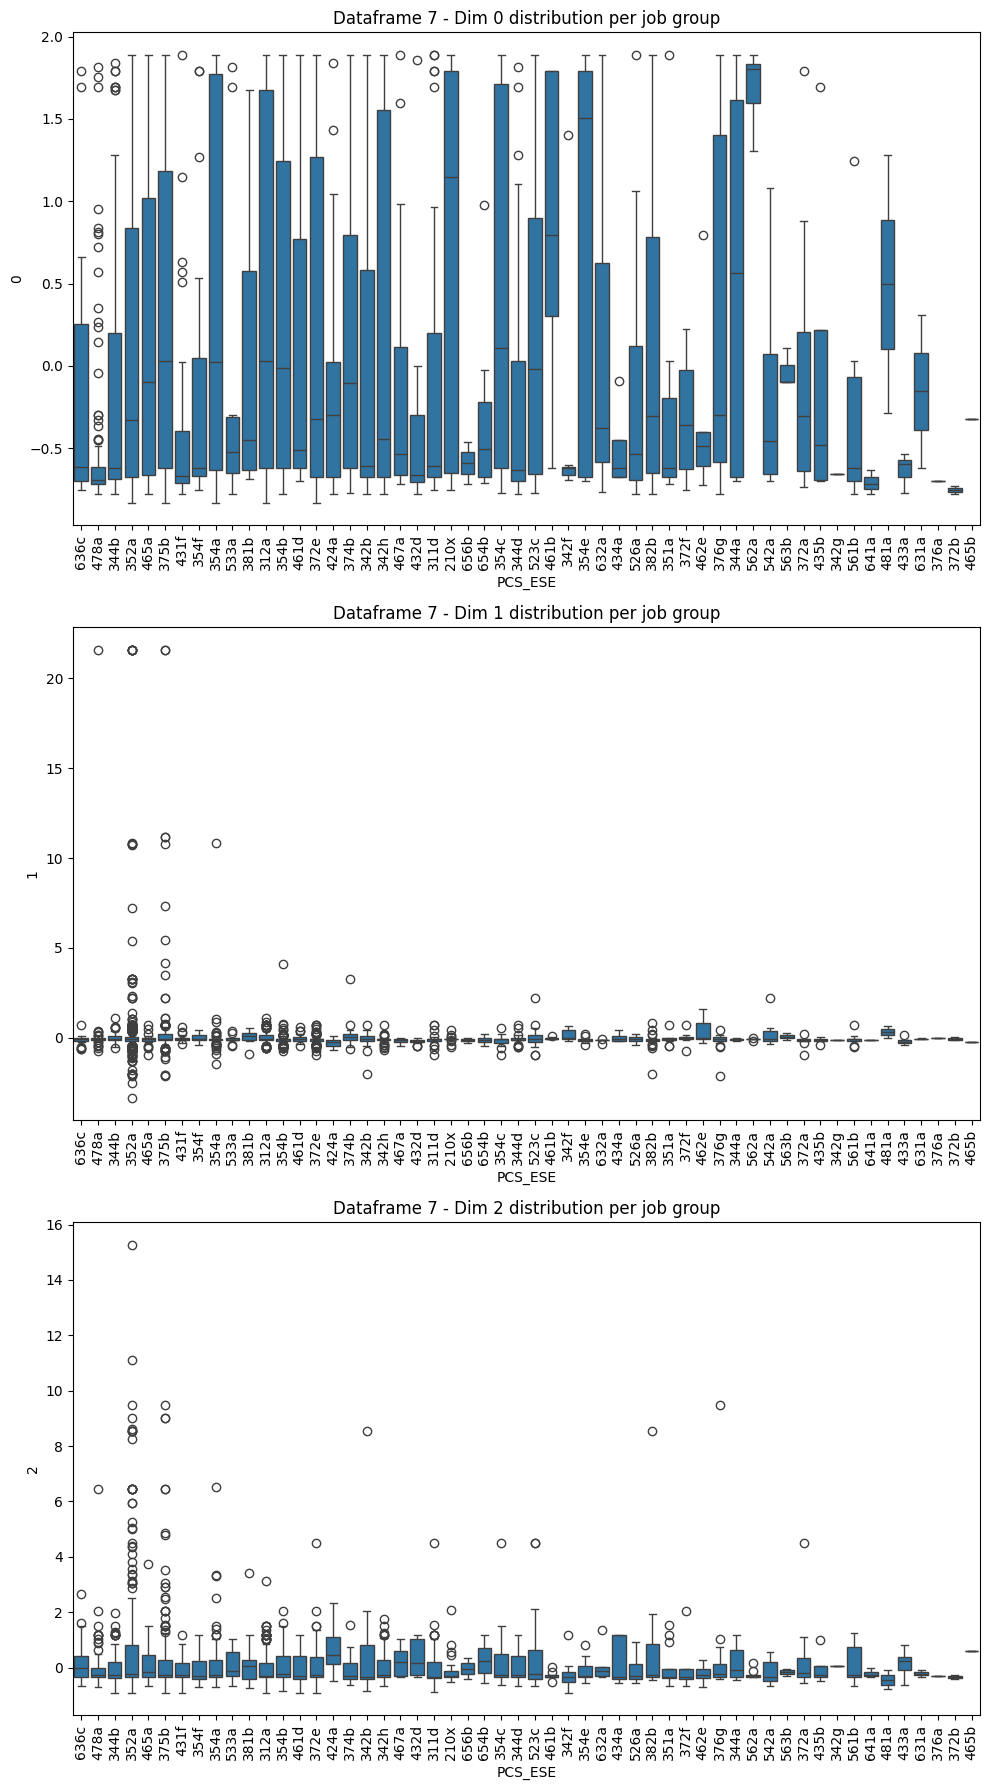

/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


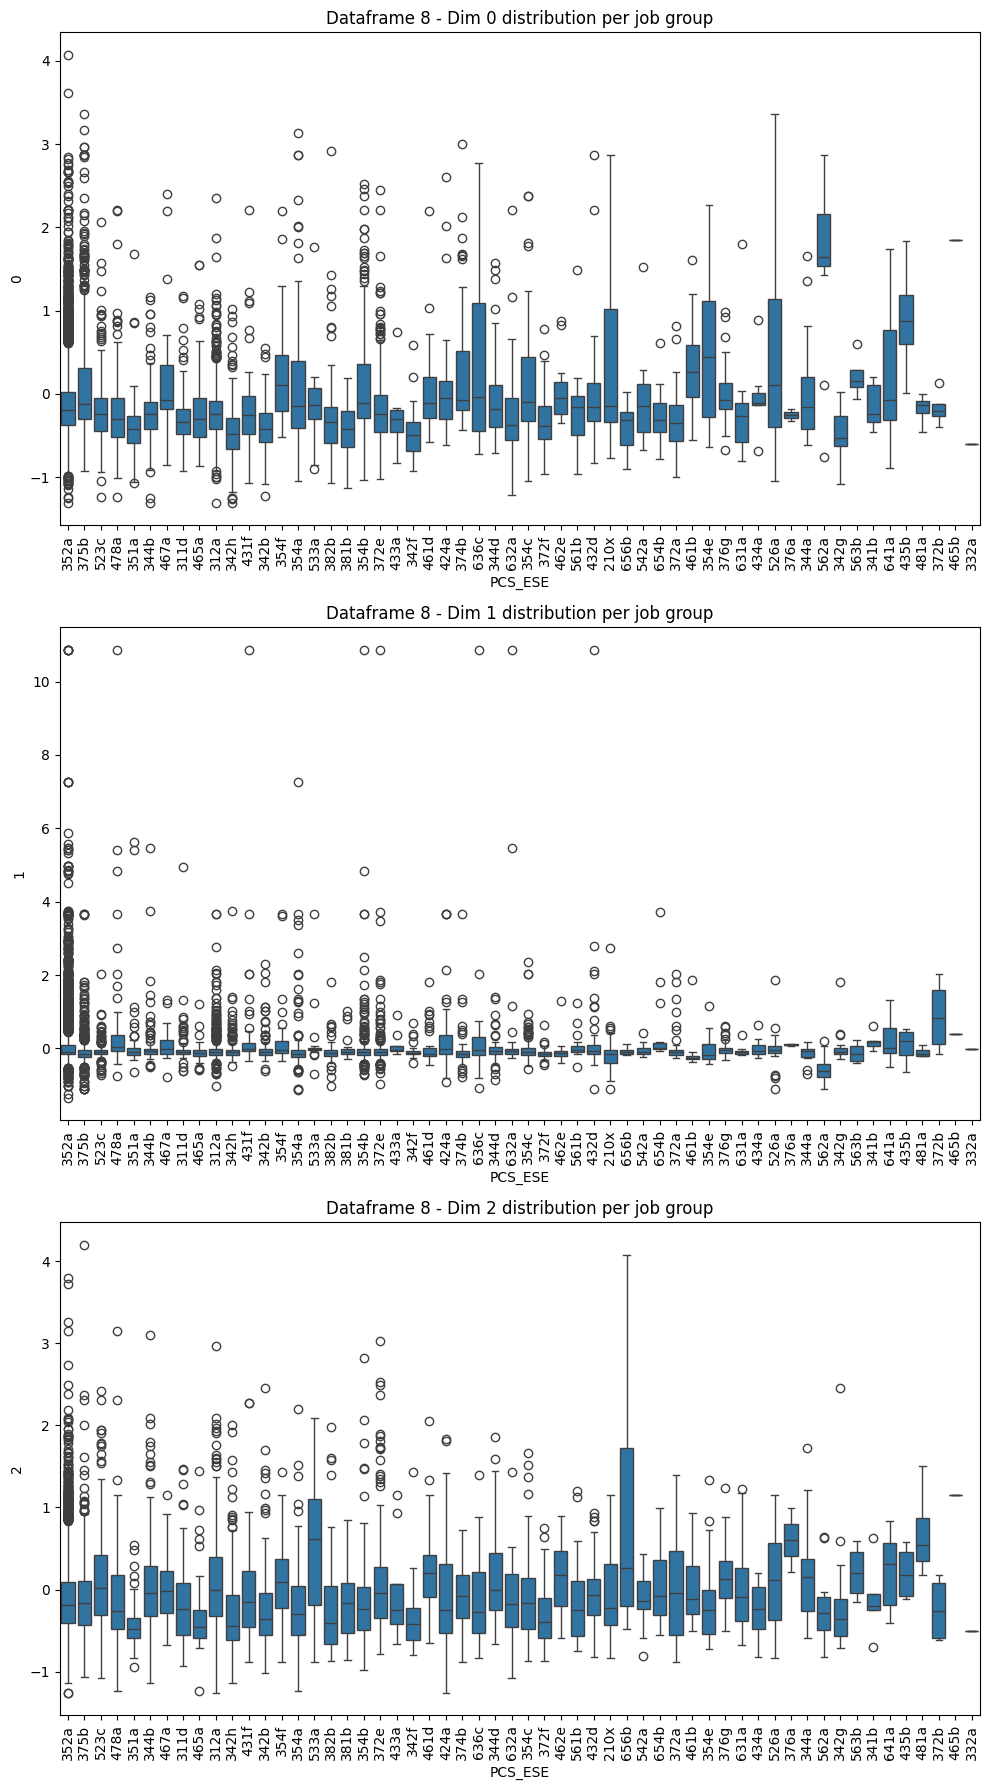

/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1148234/485456454.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


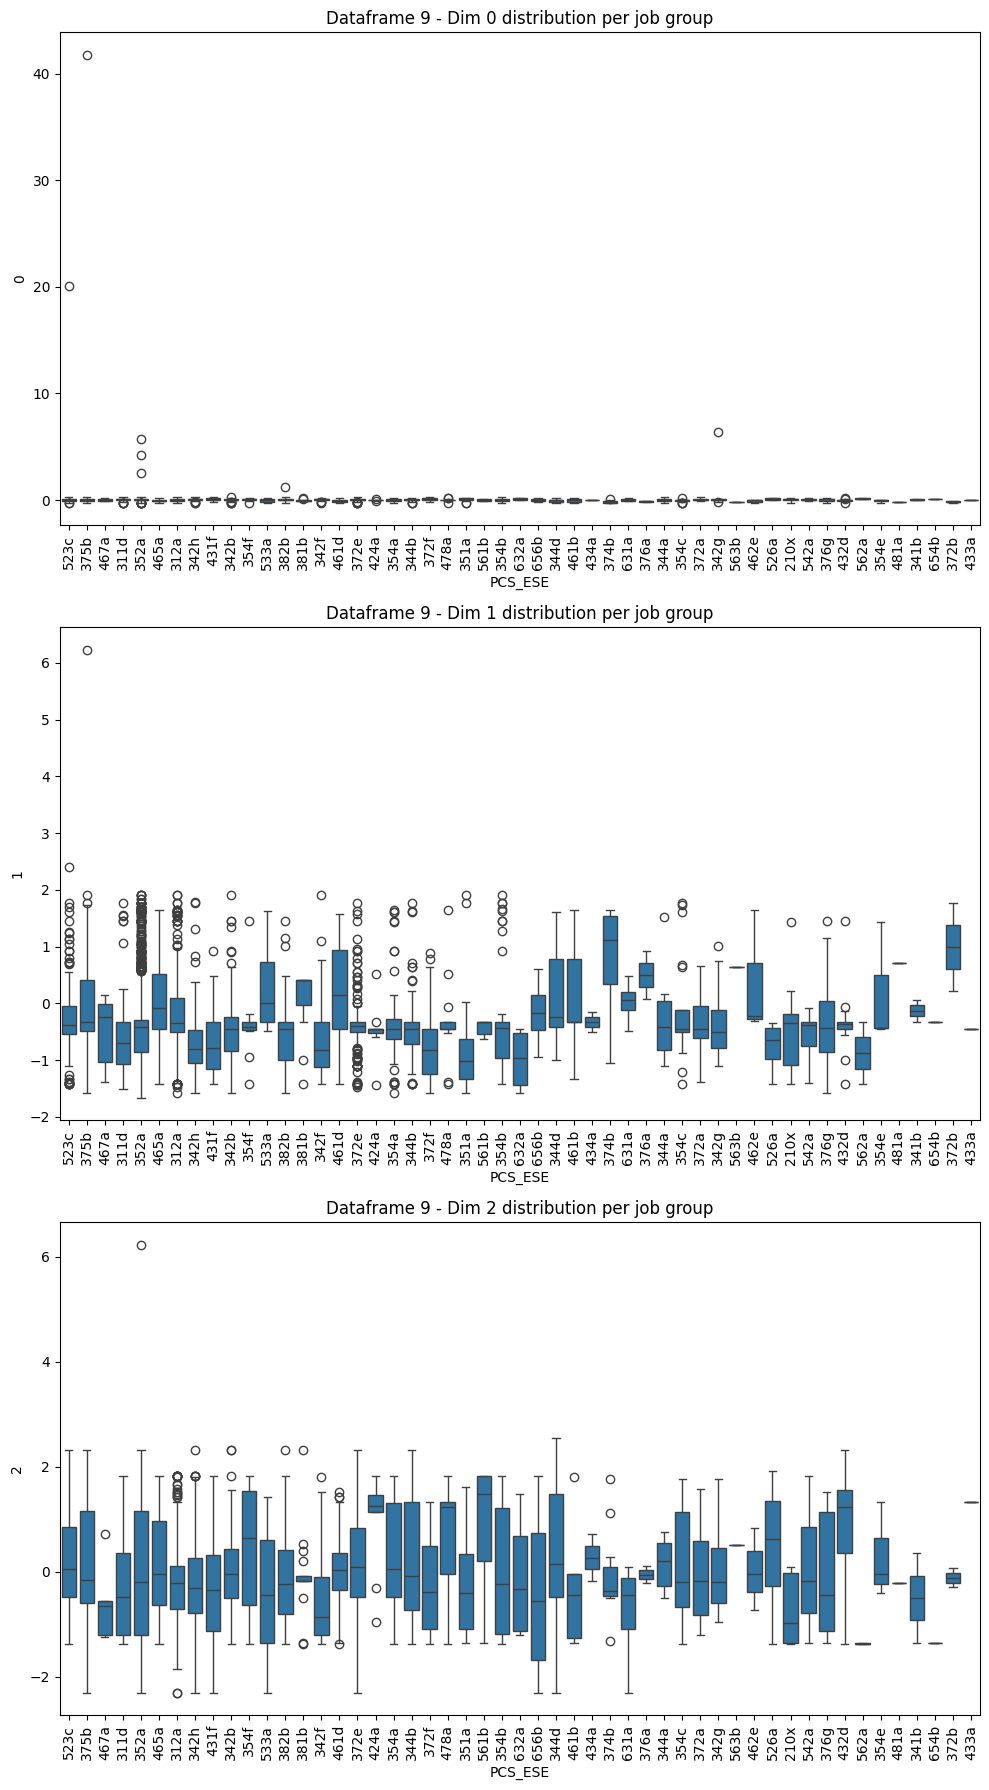

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the coordinate columns
coordinates = ['0', '1', '2']

# Loop over all dataframes
for j, df in enumerate(dfs):
    # Create a figure
    fig, axs = plt.subplots(len(coordinates), 1, figsize=(10, 18))
    
    # Create a boxplot for each coordinate column
    for i, coord in enumerate(coordinates):
        sns.boxplot(x='PCS_ESE', y=coord, data=df, ax=axs[i])
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].set_title(f'Dataframe {j+1} - Dim {coord} distribution per job group')
    
    # Adjust the layout
    plt.tight_layout()
    plt.show()

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the coordinate columns
coordinates = ['0', '1', '2']

# Loop over all dataframes
for j, df in enumerate(dfs):
     # For each coordinate column
    for coord in coordinates:
        # Calculate IQR for each job group
        Q1 = df.groupby('PCS_ESE')[coord].quantile(0.25).reset_index()
        Q3 = df.groupby('PCS_ESE')[coord].quantile(0.75).reset_index()
        IQR = Q3.set_index('PCS_ESE') - Q1.set_index('PCS_ESE')

        # Filter out the outliers
        df = df[~((df[coord] < (Q1[coord] - 1.5 * IQR[coord])) | (df[coord] > (Q3[coord] + 1.5 * IQR[coord]))).any(axis=1)]
    
    
    # Define a color map
    color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

    # Get unique color categories
    color_categories = df['PCS_ESE'].str[0].unique()

    # Plot scatter plots for each dataframe
    df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
    grouped_df = df.groupby('PCS_ESE')[coordinates + ['Salaire_moyen_en_EQTP']].mean()  # Grouped data
    grouped_df['color'] = grouped_df.index.str[0].astype(str)
    
    for predictor in coordinates:
        plt.figure(figsize=(16, 6))
        
        # Ungrouped data
        plt.subplot(1, 2, 1)
        for color in color_categories:
            plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, 'Salaire_moyen_en_EQTP'], 
                        c=color_map[color], label=f'PCE_ESE Class {color}')
        plt.xlabel(predictor)
        plt.ylabel('Salaire_moyen_en_EQTP')
        plt.title(f'Ungrouped Dataframe {j+1}: Salaire_moyen_en_EQTP vs dim {predictor}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Grouped data
        plt.subplot(1, 2, 2)
        for color in color_categories:
            plt.scatter(grouped_df.loc[grouped_df['color'] == color, predictor], 
                        grouped_df.loc[grouped_df['color'] == color, 'Salaire_moyen_en_EQTP'], 
                        color=color_map[color], label=f'PCE_ESE Class {color}')
        sns.regplot(x=grouped_df[predictor], y=grouped_df['Salaire_moyen_en_EQTP'], 
                    color='black', scatter=False, ci=95, line_kws={'linewidth': '1'})
        plt.xlabel(predictor)
        plt.ylabel('Salaire_moyen_en_EQTP')
        plt.title(f'Grouped Dataframe {j+1}: Salaire_moyen_en_EQTP vs dim {predictor}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()

ValueError: Can only compare identically-labeled Series objects

Here, I am just checking correlations between aggregated coordinate values per job title, and the income. Also checking the correlation between occupational class and income.

### 7) Independence of residuals *** no significant autocorrelation

In [6]:
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

for i, df in enumerate(dfs):
    # Fit a linear regression model
    X = sm.add_constant(df[predictors])  # Adding the intercept term
    y = df[outcome]
    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate residuals
    residuals = y - results.predict(X)

    # Apply Durbin-Watson test
    dw = durbin_watson(residuals)

    print(f'Durbin-Watson statistic for dataframe {i}: {dw}')

Durbin-Watson statistic for dataframe 0: 1.9903018029976685
Durbin-Watson statistic for dataframe 1: 1.9898706651528912
Durbin-Watson statistic for dataframe 2: 1.9922987206689473
Durbin-Watson statistic for dataframe 3: 1.9957051436355844
Durbin-Watson statistic for dataframe 4: 1.9939558264687494
Durbin-Watson statistic for dataframe 5: 1.994691965525289
Durbin-Watson statistic for dataframe 6: 2.015929925478694
Durbin-Watson statistic for dataframe 7: 1.9895332703747142
Durbin-Watson statistic for dataframe 8: 2.0508776094400596


In [ ]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')

### Assumptions Weighted Least Squares Regression
Weighted least squares (WLS), also known as weighted linear regression,[1][2] is a generalization of ordinary least squares and linear regression in which knowledge of the unequal variance of observations (heteroscedasticity) is incorporated into the regression. 

In a weighted fit, less weight is given to the
less precise measurements and more weight
to more precise measurements when
estimating the unknown parameters in the
model.
Using weights that are inversely proportional
to the variance at each level of the explanatory
variables yields the most precise parameter
estimates possible.

In [21]:
help(sm.WLS)

Help on class WLS in module statsmodels.regression.linear_model:

class WLS(RegressionModel)
 |  WLS(endog, exog, weights=1.0, missing='none', hasconst=None, **kwargs)
 |  
 |  Weighted Least Squares
 |  
 |  The weights are presumed to be (proportional to) the inverse of
 |  the variance of the observations.  That is, if the variables are
 |  to be transformed by 1/sqrt(W) you must supply weights = 1/W.
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      A 1-d endogenous response variable. The dependent variable.
 |  exog : array_like
 |      A nobs x k array where `nobs` is the number of observations and `k`
 |      is the number of regressors. An intercept is not included by default
 |      and should be added by the user. See
 |      :func:`statsmodels.tools.add_constant`.
 |  weights : array_like, optional
 |      A 1d array of weights.  If you supply 1/W then the variables are
 |      pre- multiplied by 1/sqrt(W).  If no weights are supplied the
 |      default valu

In [22]:
from sklearn.model_selection import KFold
import numpy as np

# Initialize a variable to store the best MSE, AIC, and model
best_mse = np.inf
best_aic = np.inf
best_model = None
best_i = None

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

kf = KFold(n_splits=5)

for i, df in enumerate(dfs):
    mse_scores = []
    for train_index, test_index in kf.split(df):
        # Split the data into training and test sets
        train, test = df.iloc[train_index], df.iloc[test_index]

        # Fit an initial OLS model on the training set
        X_train = sm.add_constant(train[predictors])  # Adding the intercept term
        y_train = train[outcome]
        model = sm.OLS(y_train, X_train)
        results = model.fit()

        # Calculate residuals
        residuals = y_train - results.predict(X_train)

        # Estimate weights as the inverse of the squared residuals
        weights = 1.0 / (residuals ** 2)

        # Fit a WLS model using the estimated weights
        model_wls = sm.WLS(y_train, X_train, weights=weights)
        results_wls = model_wls.fit()

        # Evaluate the model on the test set
        X_test = sm.add_constant(test[predictors])
        y_test = test[outcome]
        predictions = results_wls.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)

    # Calculate the mean MSE score
    mse_mean = np.mean(mse_scores)

    # Check if this model is better than the previous best
    if mse_mean < best_mse and results_wls.aic < best_aic:
        best_mse = mse_mean
        best_aic = results_wls.aic
        best_model = results_wls
        best_i = i

# Print the summary statistics of the best WLS regression model
print(f'Best model is from dataframe {best_i} with MSE: {best_mse} and AIC: {best_aic}')
print(best_model.summary())

Best model is from dataframe 6 with MSE: 1351149.6681207544 and AIC: 41188.338150619034
                              WLS Regression Results                             
Dep. Variable:     Salaire_moyen_en_EQTP   R-squared:                       0.611
Model:                               WLS   Adj. R-squared:                  0.610
Method:                    Least Squares   F-statistic:                     1478.
Date:                   Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                           13:13:55   Log-Likelihood:                -20590.
No. Observations:                   2831   AIC:                         4.119e+04
Df Residuals:                       2827   BIC:                         4.121e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [23]:
# Select the dataframe 6
df = dfs[6]

# Select the predictors and the outcome
variables = predictors + [outcome]

# Calculate the correlation matrix
correlation_matrix = df[variables].corr()

# Print the correlation matrix
print(correlation_matrix)

                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000  0.030733 -0.126138               0.068518
1                      0.030733  1.000000  0.149565               0.017230
2                     -0.126138  0.149565  1.000000              -0.018139
Salaire_moyen_en_EQTP  0.068518  0.017230 -0.018139               1.000000


In [39]:
# Loop over all dataframes
for i, df in enumerate(dfs):
    # Calculate the correlation matrix
    correlation_matrix = df[predictors + [outcome]].corr()
    
    # Print the correlation matrix for each dataframe
    print(f"Correlation matrix for dataframe {i}:")
    print(correlation_matrix)
    print("\n")

Correlation matrix for dataframe 0:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000  0.138253 -0.058756              -0.065998
1                      0.138253  1.000000 -0.074510               0.025687
2                     -0.058756 -0.074510  1.000000               0.014077
Salaire_moyen_en_EQTP -0.065998  0.025687  0.014077               1.000000


Correlation matrix for dataframe 1:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000 -0.151884 -0.011312               0.068042
1                     -0.151884  1.000000 -0.036709               0.010566
2                     -0.011312 -0.036709  1.000000               0.008427
Salaire_moyen_en_EQTP  0.068042  0.010566  0.008427               1.000000


Correlation matrix for dataframe 2:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000 -0.120517  0.134340            

In [40]:
# Loop over all dataframes
for i, df in enumerate(dfs):
    # Calculate the mean values for each group
    grouped_means = df.groupby('PCS_ESE')[predictors + [outcome]].mean()
    
    # Calculate the correlation matrix
    correlation_matrix = grouped_means.corr()
    
    # Print the correlation matrix for each dataframe
    print(f"Correlation matrix for dataframe {i}:")
    print(correlation_matrix)
    print("\n")

Correlation matrix for dataframe 0:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000 -0.164887  0.376979              -0.350158
1                     -0.164887  1.000000 -0.208947               0.276866
2                      0.376979 -0.208947  1.000000              -0.188425
Salaire_moyen_en_EQTP -0.350158  0.276866 -0.188425               1.000000


Correlation matrix for dataframe 1:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000  0.216007 -0.448156               0.357874
1                      0.216007  1.000000 -0.282602               0.296153
2                     -0.448156 -0.282602  1.000000              -0.144116
Salaire_moyen_en_EQTP  0.357874  0.296153 -0.144116               1.000000


Correlation matrix for dataframe 2:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000 -0.345016  0.441525            

## 3 Model Comparison

Here, I am fitting multidimensional OLS to do model selection. 
The model that gives the best fit will be selected for durther inspection. 

In [3]:
# Loading CA job coord files

importlib.reload(utils2)

dfs = []  # list to store all dataframes

for file_number in range(1, 10):  # loop over the coordinate files for models 1 to 9
    filtered_df = utils2.load_CA_model_files(file_number)
    dfs.append(filtered_df)  # add the filtered dataframe to the list

for i, df in enumerate(dfs):
    print(f"Shape of dataframe {i+1}: {df.shape}")

# Replace spaces in column names with underscores
for df in dfs:
    df.columns = df.columns.str.replace(' ', '_')

Used file path: /home/livtollanes/NewData/job_title_coordinates/m1_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m2_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m3_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m4_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m5_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m6_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m7_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m8_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m9_jobs_rowcoords.csv
Shape of dataframe 1: (11678, 14)
Shape of dataframe 2: (11677, 14)
Shape of dataframe 3: (10958, 14)
Shape of dataframe 4: (10681, 14)
Shape of dataframe 5: (10621, 14)
Shape of dataframe 6: (10626, 14)
Shape of dataframe 7: 

In [7]:
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Initialize a variable to store the best MSE, AIC, and model
best_mse = np.inf
best_aic = np.inf
best_model = None

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

kf = KFold(n_splits=5)
grouped_df = df.groupby('PCS_ESE')[predictors + [outcome]].mean()  # Grouped data


mse_scores = []
for train_index, test_index in kf.split(grouped_df):
    # Split the data into training and test sets

    train, test = grouped_df.iloc[train_index], grouped_df.iloc[test_index]

    # Fit an initial OLS model on the training set
    X_train = sm.add_constant(train[predictors])  # Adding the intercept term
    y_train = train[outcome]
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    # Calculate residuals
    residuals = y_train - results.predict(X_train)

    # Estimate weights as the inverse of the squared residuals
    weights = 1.0 / (residuals ** 2)

    # Fit a WLS model using the estimated weights
    model_wls = sm.WLS(y_train, X_train, weights=weights)
    results_wls = model_wls.fit()

    # Evaluate the model on the test set
    X_test = sm.add_constant(test[predictors])
    y_test = test[outcome]
    predictions = results_wls.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

# Calculate the mean MSE score
mse_mean = np.mean(mse_scores)

# Check if this model is better than the previous best
if mse_mean < best_mse and results_wls.aic < best_aic:
    best_mse = mse_mean
    best_aic = results_wls.aic
    best_model = results_wls

# Print the summary statistics of the best WLS regression model
print(f'Best model has MSE: {best_mse} and AIC: {best_aic}')
print(best_model.summary())

Best model has MSE: 2857942.840610682 and AIC: 635.4848571715142
                              WLS Regression Results                             
Dep. Variable:     Salaire_moyen_en_EQTP   R-squared:                       0.986
Model:                               WLS   Adj. R-squared:                  0.985
Method:                    Least Squares   F-statistic:                     887.7
Date:                   Mon, 13 May 2024   Prob (F-statistic):           1.67e-34
Time:                           15:23:15   Log-Likelihood:                -313.74
No. Observations:                     41   AIC:                             635.5
Df Residuals:                         37   BIC:                             642.3
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [12]:
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Initialize a variable to store the best MSE, AIC, and model
best_mse = np.inf
best_aic = np.inf
best_model = None
best_df = None  # Variable to store the index of the DataFrame that gives the best model

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

kf = KFold(n_splits=5)

for i, df in enumerate(dfs, start=1):  # start=1 to make the index 1-based
    mse_scores = []  # Initialize the MSE scores for each DataFrame
    for train_index, test_index in kf.split(df):
        # Split the data into training and test sets
        train, test = df.iloc[train_index], df.iloc[test_index]

        # Fit an initial OLS model on the training set
        X_train = sm.add_constant(train[predictors])  # Adding the intercept term
        y_train = train[outcome]
        model = sm.OLS(y_train, X_train)
        results = model.fit()

        # Calculate residuals
        residuals = y_train - results.predict(X_train)

        # Estimate weights as the inverse of the squared residuals
        weights = 1.0 / (residuals ** 2)

        # Fit a WLS model using the estimated weights
        model_wls = sm.WLS(y_train, X_train, weights=weights)
        results_wls = model_wls.fit()

        # Evaluate the model on the test set
        X_test = sm.add_constant(test[predictors])
        y_test = test[outcome]
        predictions = results_wls.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)

    # Calculate the mean MSE score for the current DataFrame
    mse_mean = np.mean(mse_scores)

    # Check if this model is better than the previous best
    if mse_mean < best_mse and results_wls.aic < best_aic:
        best_mse = mse_mean
        best_aic = results_wls.aic
        best_model = results_wls
        best_df = i  # Update the index of the DataFrame that gives the best model

# Print the summary statistics of the best WLS regression model
print(f'Best model from DataFrame {best_df} has MSE: {best_mse} and AIC: {best_aic}')
print(best_model.summary())

Best model from DataFrame 7 has MSE: 1351149.6681207544 and AIC: 41188.338150619034
                              WLS Regression Results                             
Dep. Variable:     Salaire_moyen_en_EQTP   R-squared:                       0.611
Model:                               WLS   Adj. R-squared:                  0.610
Method:                    Least Squares   F-statistic:                     1478.
Date:                   Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                           15:28:40   Log-Likelihood:                -20590.
No. Observations:                   2831   AIC:                         4.119e+04
Df Residuals:                       2827   BIC:                         4.121e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

In [13]:
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import pandas as pd

# Initialize a variable to store the best MSE, AIC, and model
best_mse = np.inf
best_aic = np.inf
best_model = None
best_df = None  # Variable to store the index of the DataFrame that gives the best model

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

kf = KFold(n_splits=5)

mse_values = {}  # Dictionary to store the MSE values for each DataFrame

for i, df in enumerate(dfs, start=1):  # start=1 to make the index 1-based
    mse_scores = []  # Initialize the MSE scores for each DataFrame
    for train_index, test_index in kf.split(df):
        # Split the data into training and test sets
        train, test = df.iloc[train_index], df.iloc[test_index]

        # Fit an initial OLS model on the training set
        X_train = sm.add_constant(train[predictors])  # Adding the intercept term
        y_train = train[outcome]
        model = sm.OLS(y_train, X_train)
        results = model.fit()

        # Calculate residuals
        residuals = y_train - results.predict(X_train)

        # Estimate weights as the inverse of the squared residuals
        weights = 1.0 / (residuals ** 2)

        # Fit a WLS model using the estimated weights
        model_wls = sm.WLS(y_train, X_train, weights=weights)
        results_wls = model_wls.fit()

        # Evaluate the model on the test set
        X_test = sm.add_constant(test[predictors])
        y_test = test[outcome]
        predictions = results_wls.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)

    # Calculate the mean MSE score for the current DataFrame
    mse_mean = np.mean(mse_scores)
    mse_values[f'DataFrame {i}'] = mse_mean  # Store the MSE value for the current DataFrame

    # Check if this model is better than the previous best
    if mse_mean < best_mse and results_wls.aic < best_aic:
        best_mse = mse_mean
        best_aic = results_wls.aic
        best_model = results_wls
        best_df = i  # Update the index of the DataFrame that gives the best model

# Print the summary statistics of the best WLS regression model
print(f'Best model from DataFrame {best_df} has MSE: {best_mse} and AIC: {best_aic}')
print(best_model.summary())

# Convert the dictionary to a DataFrame and display it
mse_table = pd.DataFrame(list(mse_values.items()), columns=['DataFrame', 'MSE'])
print(mse_table)

Best model from DataFrame 7 has MSE: 1351149.6681207544 and AIC: 41188.338150619034
                              WLS Regression Results                             
Dep. Variable:     Salaire_moyen_en_EQTP   R-squared:                       0.611
Model:                               WLS   Adj. R-squared:                  0.610
Method:                    Least Squares   F-statistic:                     1478.
Date:                   Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                           15:30:23   Log-Likelihood:                -20590.
No. Observations:                   2831   AIC:                         4.119e+04
Df Residuals:                       2827   BIC:                         4.121e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

In [14]:
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

# Initialize a variable to store the best MSE, AIC, and model
best_mse = np.inf
best_aic = np.inf
best_model = None
best_df = None  # Variable to store the index of the DataFrame that gives the best model

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

kf = KFold(n_splits=5)

mse_values = {}  # Dictionary to store the MSE values for each DataFrame
mae_values = {}  # Dictionary to store the MAE values for each DataFrame

for i, df in enumerate(dfs, start=1):  # start=1 to make the index 1-based
    mse_scores = []  # Initialize the MSE scores for each DataFrame
    mae_scores = []  # Initialize the MAE scores for each DataFrame
    for train_index, test_index in kf.split(df):
        # Split the data into training and test sets
        train, test = df.iloc[train_index], df.iloc[test_index]

        # Fit an initial OLS model on the training set
        X_train = sm.add_constant(train[predictors])  # Adding the intercept term
        y_train = train[outcome]
        model = sm.OLS(y_train, X_train)
        results = model.fit()

        # Calculate residuals
        residuals = y_train - results.predict(X_train)

        # Estimate weights as the inverse of the squared residuals
        weights = 1.0 / (residuals ** 2)

        # Fit a WLS model using the estimated weights
        model_wls = sm.WLS(y_train, X_train, weights=weights)
        results_wls = model_wls.fit()

        # Evaluate the model on the test set
        X_test = sm.add_constant(test[predictors])
        y_test = test[outcome]
        predictions = results_wls.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        mse_scores.append(mse)
        mae_scores.append(mae)

    # Calculate the mean MSE and MAE scores for the current DataFrame
    mse_mean = np.mean(mse_scores)
    mae_mean = np.mean(mae_scores)
    mse_values[f'DataFrame {i}'] = mse_mean  # Store the MSE value for the current DataFrame
    mae_values[f'DataFrame {i}'] = mae_mean  # Store the MAE value for the current DataFrame

    # Check if this model is better than the previous best
    if mse_mean < best_mse and results_wls.aic < best_aic:
        best_mse = mse_mean
        best_aic = results_wls.aic
        best_model = results_wls
        best_df = i  # Update the index of the DataFrame that gives the best model

# Print the summary statistics of the best WLS regression model
print(f'Best model from DataFrame {best_df} has MSE: {best_mse}, MAE: {mae_values[f"DataFrame {best_df}"]} and AIC: {best_aic}')
print(best_model.summary())

# Convert the dictionaries to a DataFrame and display it
mse_table = pd.DataFrame(list(mse_values.items()), columns=['DataFrame', 'MSE'])
mae_table = pd.DataFrame(list(mae_values.items()), columns=['DataFrame', 'MAE'])
result_table = pd.merge(mse_table, mae_table, on='DataFrame')
print(result_table)

Best model from DataFrame 7 has MSE: 1351149.6681207544, MAE: 694.2032704594969 and AIC: 41188.338150619034
                              WLS Regression Results                             
Dep. Variable:     Salaire_moyen_en_EQTP   R-squared:                       0.611
Model:                               WLS   Adj. R-squared:                  0.610
Method:                    Least Squares   F-statistic:                     1478.
Date:                   Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                           15:33:36   Log-Likelihood:                -20590.
No. Observations:                   2831   AIC:                         4.119e+04
Df Residuals:                       2827   BIC:                         4.121e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      